<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [VAE2] - First VAE, using a subclass model (MNIST dataset)
<!-- DESC --> Construction and training of a VAE, using model subclass, with a latent space of small dimension.

<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Understanding and implementing a **variational autoencoder** neurals network (VAE)
 - Understanding a still more **advanced programming model**

The calculation needs being important, it is preferable to use a very simple dataset such as MNIST to start with.  
...MNIST with a small scale if you haven't a GPU ;-)

## What we're going to do :

 - Defining a VAE model
 - Build the model
 - Train it
 - Have a look on the train process

## Acknowledgements :
Thanks to **François Chollet** who is at the base of this example (and the creator of Keras !!).  
See : https://keras.io/examples/generative/vae


## Step 1 - Init python stuff

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import sys

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import TensorBoard

from modules.models    import VAE
from modules.layers    import SamplingLayer
from modules.callbacks import ImagesCallback, BestModelCallback
from modules.datagen   import MNIST

sys.path.append('..')
import fidle.pwk as pwk

run_dir = './run/VAE2.005'
datasets_dir = pwk.init('VAE2', run_dir)

VAE.about()

**\*\* Overrided parameters : \*\***

run_dir              : ./run/VAE2_done_005


<br>**FIDLE 2020 - Practical Work Module**

Version              : 2.0.22
Notebook id          : VAE2
Run time             : Monday 22 March 2021, 14:46:59
TensorFlow version   : 2.4.0
Keras version        : 2.4.0
Datasets dir         : /gpfswork/rech/mlh/uja62cb/datasets
Run dir              : ./run/VAE2_done_005
Update keras cache   : False
Save figs            : True
Path figs            : ./run/VAE2_done_005/figs


<br>**FIDLE 2021 - VAE**

Version              : 1.4
TensorFlow version   : 2.4.0
Keras version        : 2.4.0


## Step 2 - Parameters
`scale` : With scale=1, we need 1'30s on a GPU V100 ...and >20' on a CPU !\
`latent_dim` : 2 dimensions is small, but usefull to draw !


`loss_weights` : Our **loss function** is the weighted sum of two loss:
 - `r_loss` which measures the loss during reconstruction.  
 - `kl_loss` which measures the dispersion.  

The weights are defined by: `loss_weights=[k1,k2]` where : `total_loss = k1*r_loss + k2*kl_loss`  
In practice, a value of \[1,6e-4\] gives good results here.


In [2]:
latent_dim    = 2
loss_weights  = [1,6e-4]

scale         = 1
seed          = 123

batch_size    = 64
epochs        = 10

Override parameters (batch mode) - Just forget this cell

In [3]:
pwk.override('latent_dim', 'loss_weights', 'scale', 'seed', 'batch_size', 'epochs')

**\*\* Overrided parameters : \*\***

latent_dim           : 2
loss_weights         : [1, 0.005]
scale                : 1
seed                 : 123
batch_size           : 64
epochs               : 10


## Step 3 - Prepare data
`MNIST.get_data()` return : `x_train,y_train, x_test,y_test`,  \
but we only need x_train for our training.

Seeded (123)


Dataset loaded.
Concatenated.
Shuffled.
rescaled (1).
Normalized.
Reshaped.
splited (1).


x_train shape is  :  (70000, 28, 28, 1)
x_test  shape is  :  (0, 28, 28, 1)
y_train shape is  :  (70000,)
y_test  shape is  :  (0,)
Blake2b digest is :  0c903710d4d28b01c174


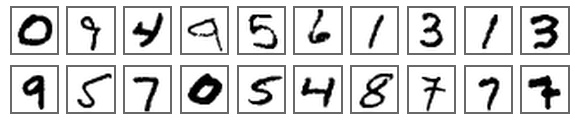

In [4]:
x_data, y_data, _,_ = MNIST.get_data(seed=seed, scale=scale, train_prop=1 )

pwk.plot_images(x_data[:20], None, indices='all', columns=10, x_size=1,y_size=1,y_padding=0, save_as='01-original')

## Step 4 - Build model
In this example, we will use a **custom model**.
For this, we will use :
 - `SamplingLayer`, which generates a vector z from the parameters z_mean and z_log_var - See : [SamplingLayer.py](./modules/layers/SamplingLayer.py)
 - `VAE`, a custom model with a specific train_step - See : [VAE.py](./modules/models/VAE.py)

#### Encoder

In [5]:
inputs    = keras.Input(shape=(28, 28, 1))
x         = layers.Conv2D(32, 3, strides=1, padding="same", activation="relu")(inputs)
x         = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
x         = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
x         = layers.Conv2D(64, 3, strides=1, padding="same", activation="relu")(x)
x         = layers.Flatten()(x)
x         = layers.Dense(16, activation="relu")(x)

z_mean    = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z         = SamplingLayer()([z_mean, z_log_var])

encoder = keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")
encoder.compile()

#### Decoder

In [6]:
inputs  = keras.Input(shape=(latent_dim,))
x       = layers.Dense(7 * 7 * 64, activation="relu")(inputs)
x       = layers.Reshape((7, 7, 64))(x)
x       = layers.Conv2DTranspose(64, 3, strides=1, padding="same", activation="relu")(x)
x       = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
x       = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)
outputs = layers.Conv2DTranspose(1,  3, padding="same", activation="sigmoid")(x)

decoder = keras.Model(inputs, outputs, name="decoder")
decoder.compile()

#### VAE
`VAE` is a custom model with a specific train_step - See : [VAE.py](./modules/models/VAE.py)

In [7]:
vae = VAE(encoder, decoder, loss_weights)

vae.compile(optimizer='adam')

Fidle VAE is ready :-)  loss_weights=[1, 0.005]


## Step 5 - Train
### 5.1 - Using two nice custom callbacks :-)
Two custom callbacks are used:
 - `ImagesCallback` : qui va sauvegarder des images durant l'apprentissage - See [ImagesCallback.py](./modules/callbacks/ImagesCallback.py)
 - `BestModelCallback` : qui sauvegardera le meilleur model - See [BestModelCallback.py](./modules/callbacks/BestModelCallback.py)

In [8]:
callback_images      = ImagesCallback(x=x_data, z_dim=latent_dim, nb_images=5, from_z=True, from_random=True, run_dir=run_dir)
callback_bestmodel   = BestModelCallback( run_dir + '/models/best_model.h5' )
callback_tensorboard = TensorBoard(log_dir=run_dir + '/logs', histogram_freq=1)

callbacks_list = [callback_images, callback_bestmodel]

### 5.2 - Let's train !
With `scale=1`, need 1'15 on a GPU (V100 at IDRIS) ...or 20' on a CPU  

In [9]:
pwk.chrono_start()

history = vae.fit(x_data, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list,)

pwk.chrono_show()

Epoch 1/10


   1/1094 [..............................] - ETA: 1:08:07 - loss: 0.6929 - r_loss: 0.6929 - kl_loss: 3.6659e-07

  12/1094 [..............................] - ETA: 5s - loss: 0.6419 - r_loss: 0.6367 - kl_loss: 0.0052         

  24/1094 [..............................] - ETA: 4s - loss: 0.5514 - r_loss: 0.5478 - kl_loss: 0.0036

  36/1094 [..............................] - ETA: 4s - loss: 0.4927 - r_loss: 0.4903 - kl_loss: 0.0024

  48/1094 [>.............................] - ETA: 4s - loss: 0.4437 - r_loss: 0.4419 - kl_loss: 0.0018

  60/1094 [>.............................] - ETA: 4s - loss: 0.4101 - r_loss: 0.4086 - kl_loss: 0.0014

  72/1094 [>.............................] - ETA: 4s - loss: 0.3873 - r_loss: 0.3861 - kl_loss: 0.0012

  84/1094 [=>............................] - ETA: 4s - loss: 0.3708 - r_loss: 0.3698 - kl_loss: 0.0010

  96/1094 [=>............................] - ETA: 4s - loss: 0.3584 - r_loss: 0.3575 - kl_loss: 9.0338e-04

 108/1094 [=>............................] - ETA: 4s - loss: 0.3483 - r_loss: 0.3475 - kl_loss: 8.0456e-04

 120/1094 [==>...........................] - ETA: 4s - loss: 0.3397 - r_loss: 0.3390 - kl_loss: 7.2855e-04

 132/1094 [==>...........................] - ETA: 4s - loss: 0.3335 - r_loss: 0.3329 - kl_loss: 6.7430e-04

 144/1094 [==>...........................] - ETA: 4s - loss: 0.3279 - r_loss: 0.3273 - kl_loss: 6.2929e-04

 156/1094 [===>..........................] - ETA: 4s - loss: 0.3230 - r_loss: 0.3224 - kl_loss: 6.1575e-04

 168/1094 [===>..........................] - ETA: 4s - loss: 0.3192 - r_loss: 0.3185 - kl_loss: 6.6866e-04

 180/1094 [===>..........................] - ETA: 4s - loss: 0.3153 - r_loss: 0.3146 - kl_loss: 7.8935e-04

 192/1094 [====>.........................] - ETA: 3s - loss: 0.3120 - r_loss: 0.3111 - kl_loss: 9.0015e-04

 204/1094 [====>.........................] - ETA: 3s - loss: 0.3088 - r_loss: 0.3078 - kl_loss: 0.0011    

 216/1094 [====>.........................] - ETA: 3s - loss: 0.3060 - r_loss: 0.3048 - kl_loss: 0.0012

 228/1094 [=====>........................] - ETA: 3s - loss: 0.3037 - r_loss: 0.3023 - kl_loss: 0.0014

 240/1094 [=====>........................] - ETA: 3s - loss: 0.3014 - r_loss: 0.2999 - kl_loss: 0.0015

 252/1094 [=====>........................] - ETA: 3s - loss: 0.2993 - r_loss: 0.2977 - kl_loss: 0.0016

 264/1094 [======>.......................] - ETA: 3s - loss: 0.2975 - r_loss: 0.2958 - kl_loss: 0.0017

 276/1094 [======>.......................] - ETA: 3s - loss: 0.2957 - r_loss: 0.2939 - kl_loss: 0.0018

 288/1094 [======>.......................] - ETA: 3s - loss: 0.2940 - r_loss: 0.2920 - kl_loss: 0.0019

 300/1094 [=======>......................] - ETA: 3s - loss: 0.2927 - r_loss: 0.2906 - kl_loss: 0.0020

 312/1094 [=======>......................] - ETA: 3s - loss: 0.2912 - r_loss: 0.2891 - kl_loss: 0.0021

 324/1094 [=======>......................] - ETA: 3s - loss: 0.2899 - r_loss: 0.2877 - kl_loss: 0.0022

 336/1094 [========>.....................] - ETA: 3s - loss: 0.2886 - r_loss: 0.2863 - kl_loss: 0.0023

 348/1094 [========>.....................] - ETA: 3s - loss: 0.2874 - r_loss: 0.2851 - kl_loss: 0.0024

 360/1094 [========>.....................] - ETA: 3s - loss: 0.2863 - r_loss: 0.2838 - kl_loss: 0.0024

 372/1094 [=========>....................] - ETA: 3s - loss: 0.2851 - r_loss: 0.2826 - kl_loss: 0.0025

 384/1094 [=========>....................] - ETA: 3s - loss: 0.2840 - r_loss: 0.2814 - kl_loss: 0.0026

 396/1094 [=========>....................] - ETA: 3s - loss: 0.2831 - r_loss: 0.2805 - kl_loss: 0.0026

 408/1094 [==========>...................] - ETA: 3s - loss: 0.2823 - r_loss: 0.2795 - kl_loss: 0.0027

 420/1094 [==========>...................] - ETA: 2s - loss: 0.2813 - r_loss: 0.2785 - kl_loss: 0.0028

 432/1094 [==========>...................] - ETA: 2s - loss: 0.2805 - r_loss: 0.2776 - kl_loss: 0.0028

 444/1094 [===========>..................] - ETA: 2s - loss: 0.2798 - r_loss: 0.2769 - kl_loss: 0.0029

 456/1094 [===========>..................] - ETA: 2s - loss: 0.2791 - r_loss: 0.2761 - kl_loss: 0.0029

 468/1094 [===========>..................] - ETA: 2s - loss: 0.2784 - r_loss: 0.2754 - kl_loss: 0.0030

 480/1094 [============>.................] - ETA: 2s - loss: 0.2778 - r_loss: 0.2747 - kl_loss: 0.0031

 492/1094 [============>.................] - ETA: 2s - loss: 0.2772 - r_loss: 0.2740 - kl_loss: 0.0031

 504/1094 [============>.................] - ETA: 2s - loss: 0.2766 - r_loss: 0.2734 - kl_loss: 0.0032

 516/1094 [=============>................] - ETA: 2s - loss: 0.2759 - r_loss: 0.2727 - kl_loss: 0.0032

 528/1094 [=============>................] - ETA: 2s - loss: 0.2753 - r_loss: 0.2720 - kl_loss: 0.0033

 540/1094 [=============>................] - ETA: 2s - loss: 0.2748 - r_loss: 0.2714 - kl_loss: 0.0033

 552/1094 [==============>...............] - ETA: 2s - loss: 0.2742 - r_loss: 0.2709 - kl_loss: 0.0034

 564/1094 [==============>...............] - ETA: 2s - loss: 0.2736 - r_loss: 0.2702 - kl_loss: 0.0034

 576/1094 [==============>...............] - ETA: 2s - loss: 0.2730 - r_loss: 0.2695 - kl_loss: 0.0035

 588/1094 [===============>..............] - ETA: 2s - loss: 0.2724 - r_loss: 0.2689 - kl_loss: 0.0035

 600/1094 [===============>..............] - ETA: 2s - loss: 0.2718 - r_loss: 0.2682 - kl_loss: 0.0036

 612/1094 [===============>..............] - ETA: 2s - loss: 0.2712 - r_loss: 0.2675 - kl_loss: 0.0036

 624/1094 [================>.............] - ETA: 2s - loss: 0.2706 - r_loss: 0.2669 - kl_loss: 0.0037

 636/1094 [================>.............] - ETA: 2s - loss: 0.2700 - r_loss: 0.2663 - kl_loss: 0.0038

 648/1094 [================>.............] - ETA: 1s - loss: 0.2694 - r_loss: 0.2655 - kl_loss: 0.0039

 660/1094 [=================>............] - ETA: 1s - loss: 0.2687 - r_loss: 0.2648 - kl_loss: 0.0039

 672/1094 [=================>............] - ETA: 1s - loss: 0.2681 - r_loss: 0.2641 - kl_loss: 0.0040

 684/1094 [=================>............] - ETA: 1s - loss: 0.2675 - r_loss: 0.2634 - kl_loss: 0.0041

 696/1094 [==================>...........] - ETA: 1s - loss: 0.2669 - r_loss: 0.2627 - kl_loss: 0.0042

 708/1094 [==================>...........] - ETA: 1s - loss: 0.2663 - r_loss: 0.2620 - kl_loss: 0.0043

 720/1094 [==================>...........] - ETA: 1s - loss: 0.2656 - r_loss: 0.2613 - kl_loss: 0.0043

 732/1094 [===================>..........] - ETA: 1s - loss: 0.2651 - r_loss: 0.2606 - kl_loss: 0.0044

 744/1094 [===================>..........] - ETA: 1s - loss: 0.2645 - r_loss: 0.2600 - kl_loss: 0.0045

 756/1094 [===================>..........] - ETA: 1s - loss: 0.2639 - r_loss: 0.2593 - kl_loss: 0.0046

 768/1094 [====================>.........] - ETA: 1s - loss: 0.2633 - r_loss: 0.2587 - kl_loss: 0.0046

 780/1094 [====================>.........] - ETA: 1s - loss: 0.2628 - r_loss: 0.2581 - kl_loss: 0.0047

 792/1094 [====================>.........] - ETA: 1s - loss: 0.2623 - r_loss: 0.2575 - kl_loss: 0.0048

 804/1094 [=====================>........] - ETA: 1s - loss: 0.2617 - r_loss: 0.2568 - kl_loss: 0.0049

 816/1094 [=====================>........] - ETA: 1s - loss: 0.2611 - r_loss: 0.2562 - kl_loss: 0.0049

 828/1094 [=====================>........] - ETA: 1s - loss: 0.2606 - r_loss: 0.2556 - kl_loss: 0.0050

 840/1094 [======================>.......] - ETA: 1s - loss: 0.2601 - r_loss: 0.2550 - kl_loss: 0.0051

 852/1094 [======================>.......] - ETA: 1s - loss: 0.2596 - r_loss: 0.2544 - kl_loss: 0.0052

 864/1094 [======================>.......] - ETA: 1s - loss: 0.2591 - r_loss: 0.2538 - kl_loss: 0.0052

 876/1094 [=======================>......] - ETA: 0s - loss: 0.2586 - r_loss: 0.2533 - kl_loss: 0.0053

 888/1094 [=======================>......] - ETA: 0s - loss: 0.2581 - r_loss: 0.2527 - kl_loss: 0.0054

 900/1094 [=======================>......] - ETA: 0s - loss: 0.2576 - r_loss: 0.2522 - kl_loss: 0.0054

 912/1094 [========================>.....] - ETA: 0s - loss: 0.2571 - r_loss: 0.2516 - kl_loss: 0.0055

 924/1094 [========================>.....] - ETA: 0s - loss: 0.2566 - r_loss: 0.2511 - kl_loss: 0.0055

 936/1094 [========================>.....] - ETA: 0s - loss: 0.2561 - r_loss: 0.2506 - kl_loss: 0.0056

 948/1094 [========================>.....] - ETA: 0s - loss: 0.2557 - r_loss: 0.2501 - kl_loss: 0.0057

 960/1094 [=========================>....] - ETA: 0s - loss: 0.2553 - r_loss: 0.2496 - kl_loss: 0.0057

 972/1094 [=========================>....] - ETA: 0s - loss: 0.2549 - r_loss: 0.2491 - kl_loss: 0.0058

 984/1094 [=========================>....] - ETA: 0s - loss: 0.2544 - r_loss: 0.2486 - kl_loss: 0.0058

 996/1094 [==========================>...] - ETA: 0s - loss: 0.2540 - r_loss: 0.2481 - kl_loss: 0.0059

1008/1094 [==========================>...] - ETA: 0s - loss: 0.2535 - r_loss: 0.2476 - kl_loss: 0.0059

1020/1094 [==========================>...] - ETA: 0s - loss: 0.2531 - r_loss: 0.2471 - kl_loss: 0.0060

1032/1094 [===========================>..] - ETA: 0s - loss: 0.2526 - r_loss: 0.2466 - kl_loss: 0.0060

1044/1094 [===========================>..] - ETA: 0s - loss: 0.2523 - r_loss: 0.2462 - kl_loss: 0.0061

1056/1094 [===========================>..] - ETA: 0s - loss: 0.2519 - r_loss: 0.2457 - kl_loss: 0.0061

1068/1094 [============================>.] - ETA: 0s - loss: 0.2515 - r_loss: 0.2453 - kl_loss: 0.0062

1080/1094 [============================>.] - ETA: 0s - loss: 0.2511 - r_loss: 0.2448 - kl_loss: 0.0062

1092/1094 [============================>.] - ETA: 0s - loss: 0.2507 - r_loss: 0.2444 - kl_loss: 0.0063

1094/1094 [==============================] - ETA: 0s - loss: 0.2506 - r_loss: 0.2443 - kl_loss: 0.0063

1094/1094 [==============================] - 9s 4ms/step - loss: 0.2506 - r_loss: 0.2443 - kl_loss: 0.0063


Epoch 2/10
   1/1094 [..............................] - ETA: 5s - loss: 0.2173 - r_loss: 0.2064 - kl_loss: 0.0110

  13/1094 [..............................] - ETA: 4s - loss: 0.2199 - r_loss: 0.2096 - kl_loss: 0.0103

  25/1094 [..............................] - ETA: 4s - loss: 0.2164 - r_loss: 0.2058 - kl_loss: 0.0106

  37/1094 [>.............................] - ETA: 4s - loss: 0.2167 - r_loss: 0.2062 - kl_loss: 0.0106

  49/1094 [>.............................] - ETA: 4s - loss: 0.2168 - r_loss: 0.2062 - kl_loss: 0.0106

  61/1094 [>.............................] - ETA: 4s - loss: 0.2164 - r_loss: 0.2059 - kl_loss: 0.0105

  73/1094 [=>............................] - ETA: 4s - loss: 0.2162 - r_loss: 0.2056 - kl_loss: 0.0106

  85/1094 [=>............................] - ETA: 4s - loss: 0.2163 - r_loss: 0.2057 - kl_loss: 0.0105

  97/1094 [=>............................] - ETA: 4s - loss: 0.2156 - r_loss: 0.2051 - kl_loss: 0.0106

 109/1094 [=>............................] - ETA: 4s - loss: 0.2155 - r_loss: 0.2049 - kl_loss: 0.0106

 121/1094 [==>...........................] - ETA: 4s - loss: 0.2154 - r_loss: 0.2048 - kl_loss: 0.0106

 133/1094 [==>...........................] - ETA: 4s - loss: 0.2155 - r_loss: 0.2049 - kl_loss: 0.0106

 145/1094 [==>...........................] - ETA: 4s - loss: 0.2152 - r_loss: 0.2046 - kl_loss: 0.0106

 157/1094 [===>..........................] - ETA: 4s - loss: 0.2151 - r_loss: 0.2045 - kl_loss: 0.0106

 169/1094 [===>..........................] - ETA: 4s - loss: 0.2152 - r_loss: 0.2046 - kl_loss: 0.0106

 181/1094 [===>..........................] - ETA: 3s - loss: 0.2153 - r_loss: 0.2047 - kl_loss: 0.0106

 193/1094 [====>.........................] - ETA: 3s - loss: 0.2149 - r_loss: 0.2043 - kl_loss: 0.0107

 205/1094 [====>.........................] - ETA: 3s - loss: 0.2150 - r_loss: 0.2044 - kl_loss: 0.0107

 217/1094 [====>.........................] - ETA: 3s - loss: 0.2149 - r_loss: 0.2043 - kl_loss: 0.0107

 229/1094 [=====>........................] - ETA: 3s - loss: 0.2150 - r_loss: 0.2043 - kl_loss: 0.0107

 241/1094 [=====>........................] - ETA: 3s - loss: 0.2149 - r_loss: 0.2043 - kl_loss: 0.0107

 253/1094 [=====>........................] - ETA: 3s - loss: 0.2146 - r_loss: 0.2039 - kl_loss: 0.0107

 265/1094 [======>.......................] - ETA: 3s - loss: 0.2143 - r_loss: 0.2036 - kl_loss: 0.0107

 277/1094 [======>.......................] - ETA: 3s - loss: 0.2143 - r_loss: 0.2036 - kl_loss: 0.0107

 289/1094 [======>.......................] - ETA: 3s - loss: 0.2142 - r_loss: 0.2035 - kl_loss: 0.0107

 301/1094 [=======>......................] - ETA: 3s - loss: 0.2141 - r_loss: 0.2034 - kl_loss: 0.0107

 313/1094 [=======>......................] - ETA: 3s - loss: 0.2141 - r_loss: 0.2033 - kl_loss: 0.0108

 325/1094 [=======>......................] - ETA: 3s - loss: 0.2140 - r_loss: 0.2032 - kl_loss: 0.0108

 337/1094 [========>.....................] - ETA: 3s - loss: 0.2137 - r_loss: 0.2029 - kl_loss: 0.0108

 349/1094 [========>.....................] - ETA: 3s - loss: 0.2134 - r_loss: 0.2026 - kl_loss: 0.0108

 361/1094 [========>.....................] - ETA: 3s - loss: 0.2131 - r_loss: 0.2023 - kl_loss: 0.0108

 373/1094 [=========>....................] - ETA: 3s - loss: 0.2132 - r_loss: 0.2024 - kl_loss: 0.0108

 385/1094 [=========>....................] - ETA: 3s - loss: 0.2131 - r_loss: 0.2023 - kl_loss: 0.0108

 397/1094 [=========>....................] - ETA: 3s - loss: 0.2130 - r_loss: 0.2022 - kl_loss: 0.0108

 409/1094 [==========>...................] - ETA: 2s - loss: 0.2130 - r_loss: 0.2022 - kl_loss: 0.0108

 421/1094 [==========>...................] - ETA: 2s - loss: 0.2129 - r_loss: 0.2021 - kl_loss: 0.0108

 433/1094 [==========>...................] - ETA: 2s - loss: 0.2128 - r_loss: 0.2020 - kl_loss: 0.0108

 445/1094 [===========>..................] - ETA: 2s - loss: 0.2128 - r_loss: 0.2020 - kl_loss: 0.0108

 457/1094 [===========>..................] - ETA: 2s - loss: 0.2128 - r_loss: 0.2019 - kl_loss: 0.0108

 469/1094 [===========>..................] - ETA: 2s - loss: 0.2128 - r_loss: 0.2019 - kl_loss: 0.0109

 481/1094 [============>.................] - ETA: 2s - loss: 0.2126 - r_loss: 0.2017 - kl_loss: 0.0109

 493/1094 [============>.................] - ETA: 2s - loss: 0.2124 - r_loss: 0.2015 - kl_loss: 0.0109

 505/1094 [============>.................] - ETA: 2s - loss: 0.2124 - r_loss: 0.2015 - kl_loss: 0.0109

 517/1094 [=============>................] - ETA: 2s - loss: 0.2124 - r_loss: 0.2015 - kl_loss: 0.0109

 529/1094 [=============>................] - ETA: 2s - loss: 0.2124 - r_loss: 0.2015 - kl_loss: 0.0109

 541/1094 [=============>................] - ETA: 2s - loss: 0.2124 - r_loss: 0.2015 - kl_loss: 0.0109

 553/1094 [==============>...............] - ETA: 2s - loss: 0.2124 - r_loss: 0.2015 - kl_loss: 0.0109

 565/1094 [==============>...............] - ETA: 2s - loss: 0.2123 - r_loss: 0.2014 - kl_loss: 0.0109

 577/1094 [==============>...............] - ETA: 2s - loss: 0.2122 - r_loss: 0.2013 - kl_loss: 0.0109

 589/1094 [===============>..............] - ETA: 2s - loss: 0.2122 - r_loss: 0.2013 - kl_loss: 0.0109

 601/1094 [===============>..............] - ETA: 2s - loss: 0.2121 - r_loss: 0.2012 - kl_loss: 0.0109

 613/1094 [===============>..............] - ETA: 2s - loss: 0.2120 - r_loss: 0.2010 - kl_loss: 0.0110

 625/1094 [================>.............] - ETA: 2s - loss: 0.2119 - r_loss: 0.2010 - kl_loss: 0.0110

 637/1094 [================>.............] - ETA: 1s - loss: 0.2118 - r_loss: 0.2008 - kl_loss: 0.0110

 649/1094 [================>.............] - ETA: 1s - loss: 0.2117 - r_loss: 0.2008 - kl_loss: 0.0110

 661/1094 [=================>............] - ETA: 1s - loss: 0.2117 - r_loss: 0.2007 - kl_loss: 0.0110

 673/1094 [=================>............] - ETA: 1s - loss: 0.2117 - r_loss: 0.2007 - kl_loss: 0.0110

 685/1094 [=================>............] - ETA: 1s - loss: 0.2117 - r_loss: 0.2007 - kl_loss: 0.0110

 697/1094 [==================>...........] - ETA: 1s - loss: 0.2116 - r_loss: 0.2006 - kl_loss: 0.0110

 709/1094 [==================>...........] - ETA: 1s - loss: 0.2115 - r_loss: 0.2005 - kl_loss: 0.0110

 721/1094 [==================>...........] - ETA: 1s - loss: 0.2115 - r_loss: 0.2004 - kl_loss: 0.0110

 733/1094 [===================>..........] - ETA: 1s - loss: 0.2114 - r_loss: 0.2004 - kl_loss: 0.0110

 745/1094 [===================>..........] - ETA: 1s - loss: 0.2113 - r_loss: 0.2003 - kl_loss: 0.0110

 757/1094 [===================>..........] - ETA: 1s - loss: 0.2113 - r_loss: 0.2002 - kl_loss: 0.0111

 769/1094 [====================>.........] - ETA: 1s - loss: 0.2112 - r_loss: 0.2001 - kl_loss: 0.0111

 781/1094 [====================>.........] - ETA: 1s - loss: 0.2111 - r_loss: 0.2000 - kl_loss: 0.0111

 793/1094 [====================>.........] - ETA: 1s - loss: 0.2110 - r_loss: 0.2000 - kl_loss: 0.0111

 805/1094 [=====================>........] - ETA: 1s - loss: 0.2110 - r_loss: 0.1999 - kl_loss: 0.0111

 817/1094 [=====================>........] - ETA: 1s - loss: 0.2110 - r_loss: 0.1999 - kl_loss: 0.0111

 829/1094 [=====================>........] - ETA: 1s - loss: 0.2110 - r_loss: 0.1999 - kl_loss: 0.0111

 841/1094 [======================>.......] - ETA: 1s - loss: 0.2109 - r_loss: 0.1998 - kl_loss: 0.0111

 853/1094 [======================>.......] - ETA: 1s - loss: 0.2108 - r_loss: 0.1996 - kl_loss: 0.0111

 865/1094 [======================>.......] - ETA: 1s - loss: 0.2106 - r_loss: 0.1995 - kl_loss: 0.0111

 877/1094 [=======================>......] - ETA: 0s - loss: 0.2106 - r_loss: 0.1995 - kl_loss: 0.0111

 889/1094 [=======================>......] - ETA: 0s - loss: 0.2107 - r_loss: 0.1995 - kl_loss: 0.0111

 901/1094 [=======================>......] - ETA: 0s - loss: 0.2106 - r_loss: 0.1995 - kl_loss: 0.0112

 913/1094 [========================>.....] - ETA: 0s - loss: 0.2106 - r_loss: 0.1994 - kl_loss: 0.0112

 925/1094 [========================>.....] - ETA: 0s - loss: 0.2105 - r_loss: 0.1993 - kl_loss: 0.0112

 937/1094 [========================>.....] - ETA: 0s - loss: 0.2104 - r_loss: 0.1992 - kl_loss: 0.0112

 949/1094 [=========================>....] - ETA: 0s - loss: 0.2103 - r_loss: 0.1991 - kl_loss: 0.0112

 961/1094 [=========================>....] - ETA: 0s - loss: 0.2103 - r_loss: 0.1991 - kl_loss: 0.0112

 973/1094 [=========================>....] - ETA: 0s - loss: 0.2102 - r_loss: 0.1991 - kl_loss: 0.0112

 985/1094 [==========================>...] - ETA: 0s - loss: 0.2102 - r_loss: 0.1990 - kl_loss: 0.0112

 997/1094 [==========================>...] - ETA: 0s - loss: 0.2102 - r_loss: 0.1990 - kl_loss: 0.0112

1009/1094 [==========================>...] - ETA: 0s - loss: 0.2101 - r_loss: 0.1989 - kl_loss: 0.0112

1021/1094 [==========================>...] - ETA: 0s - loss: 0.2100 - r_loss: 0.1988 - kl_loss: 0.0112

1033/1094 [===========================>..] - ETA: 0s - loss: 0.2099 - r_loss: 0.1987 - kl_loss: 0.0112

1045/1094 [===========================>..] - ETA: 0s - loss: 0.2098 - r_loss: 0.1986 - kl_loss: 0.0112

1057/1094 [===========================>..] - ETA: 0s - loss: 0.2098 - r_loss: 0.1985 - kl_loss: 0.0112

1069/1094 [============================>.] - ETA: 0s - loss: 0.2098 - r_loss: 0.1985 - kl_loss: 0.0112

1081/1094 [============================>.] - ETA: 0s - loss: 0.2097 - r_loss: 0.1985 - kl_loss: 0.0113

1093/1094 [============================>.] - ETA: 0s - loss: 0.2097 - r_loss: 0.1984 - kl_loss: 0.0113

1094/1094 [==============================] - 5s 4ms/step - loss: 0.2097 - r_loss: 0.1984 - kl_loss: 0.0113


Epoch 3/10
   1/1094 [..............................] - ETA: 5s - loss: 0.2097 - r_loss: 0.1978 - kl_loss: 0.0120

  13/1094 [..............................] - ETA: 4s - loss: 0.2073 - r_loss: 0.1954 - kl_loss: 0.0120

  25/1094 [..............................] - ETA: 4s - loss: 0.2059 - r_loss: 0.1941 - kl_loss: 0.0119

  37/1094 [>.............................] - ETA: 4s - loss: 0.2042 - r_loss: 0.1923 - kl_loss: 0.0119

  49/1094 [>.............................] - ETA: 4s - loss: 0.2041 - r_loss: 0.1922 - kl_loss: 0.0120

  61/1094 [>.............................] - ETA: 4s - loss: 0.2031 - r_loss: 0.1912 - kl_loss: 0.0119

  73/1094 [=>............................] - ETA: 4s - loss: 0.2040 - r_loss: 0.1921 - kl_loss: 0.0119

  85/1094 [=>............................] - ETA: 4s - loss: 0.2045 - r_loss: 0.1926 - kl_loss: 0.0119

  97/1094 [=>............................] - ETA: 4s - loss: 0.2048 - r_loss: 0.1929 - kl_loss: 0.0119

 109/1094 [=>............................] - ETA: 4s - loss: 0.2048 - r_loss: 0.1929 - kl_loss: 0.0119

 121/1094 [==>...........................] - ETA: 4s - loss: 0.2050 - r_loss: 0.1932 - kl_loss: 0.0119

 133/1094 [==>...........................] - ETA: 4s - loss: 0.2049 - r_loss: 0.1931 - kl_loss: 0.0119

 145/1094 [==>...........................] - ETA: 4s - loss: 0.2049 - r_loss: 0.1930 - kl_loss: 0.0119

 157/1094 [===>..........................] - ETA: 4s - loss: 0.2048 - r_loss: 0.1929 - kl_loss: 0.0119

 169/1094 [===>..........................] - ETA: 4s - loss: 0.2046 - r_loss: 0.1927 - kl_loss: 0.0119

 181/1094 [===>..........................] - ETA: 4s - loss: 0.2046 - r_loss: 0.1927 - kl_loss: 0.0119

 193/1094 [====>.........................] - ETA: 3s - loss: 0.2044 - r_loss: 0.1925 - kl_loss: 0.0119

 205/1094 [====>.........................] - ETA: 3s - loss: 0.2045 - r_loss: 0.1926 - kl_loss: 0.0119

 217/1094 [====>.........................] - ETA: 3s - loss: 0.2046 - r_loss: 0.1927 - kl_loss: 0.0119

 229/1094 [=====>........................] - ETA: 3s - loss: 0.2047 - r_loss: 0.1928 - kl_loss: 0.0119

 241/1094 [=====>........................] - ETA: 3s - loss: 0.2047 - r_loss: 0.1928 - kl_loss: 0.0119

 253/1094 [=====>........................] - ETA: 3s - loss: 0.2048 - r_loss: 0.1929 - kl_loss: 0.0119

 265/1094 [======>.......................] - ETA: 3s - loss: 0.2049 - r_loss: 0.1929 - kl_loss: 0.0119

 277/1094 [======>.......................] - ETA: 3s - loss: 0.2048 - r_loss: 0.1928 - kl_loss: 0.0119

 289/1094 [======>.......................] - ETA: 3s - loss: 0.2047 - r_loss: 0.1928 - kl_loss: 0.0119

 301/1094 [=======>......................] - ETA: 3s - loss: 0.2046 - r_loss: 0.1926 - kl_loss: 0.0119

 313/1094 [=======>......................] - ETA: 3s - loss: 0.2044 - r_loss: 0.1925 - kl_loss: 0.0119

 325/1094 [=======>......................] - ETA: 3s - loss: 0.2045 - r_loss: 0.1926 - kl_loss: 0.0119

 337/1094 [========>.....................] - ETA: 3s - loss: 0.2047 - r_loss: 0.1927 - kl_loss: 0.0119

 349/1094 [========>.....................] - ETA: 3s - loss: 0.2045 - r_loss: 0.1926 - kl_loss: 0.0119

 361/1094 [========>.....................] - ETA: 3s - loss: 0.2045 - r_loss: 0.1925 - kl_loss: 0.0119

 373/1094 [=========>....................] - ETA: 3s - loss: 0.2045 - r_loss: 0.1925 - kl_loss: 0.0119

 385/1094 [=========>....................] - ETA: 3s - loss: 0.2045 - r_loss: 0.1925 - kl_loss: 0.0120

 397/1094 [=========>....................] - ETA: 3s - loss: 0.2044 - r_loss: 0.1924 - kl_loss: 0.0120

 409/1094 [==========>...................] - ETA: 3s - loss: 0.2043 - r_loss: 0.1924 - kl_loss: 0.0120

 421/1094 [==========>...................] - ETA: 2s - loss: 0.2043 - r_loss: 0.1924 - kl_loss: 0.0120

 433/1094 [==========>...................] - ETA: 2s - loss: 0.2043 - r_loss: 0.1923 - kl_loss: 0.0120

 445/1094 [===========>..................] - ETA: 2s - loss: 0.2043 - r_loss: 0.1923 - kl_loss: 0.0120

 457/1094 [===========>..................] - ETA: 2s - loss: 0.2043 - r_loss: 0.1923 - kl_loss: 0.0120

 469/1094 [===========>..................] - ETA: 2s - loss: 0.2044 - r_loss: 0.1924 - kl_loss: 0.0120

 481/1094 [============>.................] - ETA: 2s - loss: 0.2044 - r_loss: 0.1924 - kl_loss: 0.0120

 493/1094 [============>.................] - ETA: 2s - loss: 0.2043 - r_loss: 0.1923 - kl_loss: 0.0120

 505/1094 [============>.................] - ETA: 2s - loss: 0.2043 - r_loss: 0.1923 - kl_loss: 0.0120

 517/1094 [=============>................] - ETA: 2s - loss: 0.2043 - r_loss: 0.1923 - kl_loss: 0.0120

 529/1094 [=============>................] - ETA: 2s - loss: 0.2043 - r_loss: 0.1923 - kl_loss: 0.0120

 541/1094 [=============>................] - ETA: 2s - loss: 0.2044 - r_loss: 0.1923 - kl_loss: 0.0120

 553/1094 [==============>...............] - ETA: 2s - loss: 0.2043 - r_loss: 0.1923 - kl_loss: 0.0120

 565/1094 [==============>...............] - ETA: 2s - loss: 0.2044 - r_loss: 0.1924 - kl_loss: 0.0120

 577/1094 [==============>...............] - ETA: 2s - loss: 0.2044 - r_loss: 0.1924 - kl_loss: 0.0120

 589/1094 [===============>..............] - ETA: 2s - loss: 0.2044 - r_loss: 0.1924 - kl_loss: 0.0120

 601/1094 [===============>..............] - ETA: 2s - loss: 0.2044 - r_loss: 0.1923 - kl_loss: 0.0121

 613/1094 [===============>..............] - ETA: 2s - loss: 0.2043 - r_loss: 0.1923 - kl_loss: 0.0121

 625/1094 [================>.............] - ETA: 2s - loss: 0.2044 - r_loss: 0.1923 - kl_loss: 0.0121

 637/1094 [================>.............] - ETA: 2s - loss: 0.2043 - r_loss: 0.1923 - kl_loss: 0.0121

 649/1094 [================>.............] - ETA: 1s - loss: 0.2043 - r_loss: 0.1922 - kl_loss: 0.0121

 661/1094 [=================>............] - ETA: 1s - loss: 0.2042 - r_loss: 0.1921 - kl_loss: 0.0121

 673/1094 [=================>............] - ETA: 1s - loss: 0.2042 - r_loss: 0.1921 - kl_loss: 0.0121

 685/1094 [=================>............] - ETA: 1s - loss: 0.2041 - r_loss: 0.1920 - kl_loss: 0.0121

 697/1094 [==================>...........] - ETA: 1s - loss: 0.2040 - r_loss: 0.1919 - kl_loss: 0.0121

 709/1094 [==================>...........] - ETA: 1s - loss: 0.2040 - r_loss: 0.1919 - kl_loss: 0.0121

 721/1094 [==================>...........] - ETA: 1s - loss: 0.2041 - r_loss: 0.1919 - kl_loss: 0.0121

 733/1094 [===================>..........] - ETA: 1s - loss: 0.2040 - r_loss: 0.1918 - kl_loss: 0.0121

 745/1094 [===================>..........] - ETA: 1s - loss: 0.2039 - r_loss: 0.1918 - kl_loss: 0.0121

 757/1094 [===================>..........] - ETA: 1s - loss: 0.2039 - r_loss: 0.1917 - kl_loss: 0.0121

 769/1094 [====================>.........] - ETA: 1s - loss: 0.2039 - r_loss: 0.1918 - kl_loss: 0.0121

 781/1094 [====================>.........] - ETA: 1s - loss: 0.2039 - r_loss: 0.1917 - kl_loss: 0.0121

 793/1094 [====================>.........] - ETA: 1s - loss: 0.2039 - r_loss: 0.1917 - kl_loss: 0.0121

 805/1094 [=====================>........] - ETA: 1s - loss: 0.2039 - r_loss: 0.1917 - kl_loss: 0.0122

 817/1094 [=====================>........] - ETA: 1s - loss: 0.2038 - r_loss: 0.1916 - kl_loss: 0.0122

 829/1094 [=====================>........] - ETA: 1s - loss: 0.2038 - r_loss: 0.1916 - kl_loss: 0.0122

 841/1094 [======================>.......] - ETA: 1s - loss: 0.2037 - r_loss: 0.1916 - kl_loss: 0.0122

 853/1094 [======================>.......] - ETA: 1s - loss: 0.2037 - r_loss: 0.1915 - kl_loss: 0.0122

 865/1094 [======================>.......] - ETA: 1s - loss: 0.2037 - r_loss: 0.1915 - kl_loss: 0.0122

 877/1094 [=======================>......] - ETA: 0s - loss: 0.2037 - r_loss: 0.1916 - kl_loss: 0.0122

 889/1094 [=======================>......] - ETA: 0s - loss: 0.2037 - r_loss: 0.1915 - kl_loss: 0.0122

 901/1094 [=======================>......] - ETA: 0s - loss: 0.2037 - r_loss: 0.1915 - kl_loss: 0.0122

 913/1094 [========================>.....] - ETA: 0s - loss: 0.2036 - r_loss: 0.1914 - kl_loss: 0.0122

 925/1094 [========================>.....] - ETA: 0s - loss: 0.2036 - r_loss: 0.1914 - kl_loss: 0.0122

 937/1094 [========================>.....] - ETA: 0s - loss: 0.2035 - r_loss: 0.1913 - kl_loss: 0.0122

 949/1094 [=========================>....] - ETA: 0s - loss: 0.2035 - r_loss: 0.1913 - kl_loss: 0.0122

 961/1094 [=========================>....] - ETA: 0s - loss: 0.2035 - r_loss: 0.1913 - kl_loss: 0.0122

 973/1094 [=========================>....] - ETA: 0s - loss: 0.2034 - r_loss: 0.1912 - kl_loss: 0.0122

 985/1094 [==========================>...] - ETA: 0s - loss: 0.2033 - r_loss: 0.1911 - kl_loss: 0.0122

 997/1094 [==========================>...] - ETA: 0s - loss: 0.2033 - r_loss: 0.1911 - kl_loss: 0.0122

1009/1094 [==========================>...] - ETA: 0s - loss: 0.2033 - r_loss: 0.1910 - kl_loss: 0.0122

1021/1094 [==========================>...] - ETA: 0s - loss: 0.2033 - r_loss: 0.1910 - kl_loss: 0.0123

1033/1094 [===========================>..] - ETA: 0s - loss: 0.2032 - r_loss: 0.1910 - kl_loss: 0.0123

1045/1094 [===========================>..] - ETA: 0s - loss: 0.2032 - r_loss: 0.1909 - kl_loss: 0.0123

1057/1094 [===========================>..] - ETA: 0s - loss: 0.2032 - r_loss: 0.1909 - kl_loss: 0.0123

1069/1094 [============================>.] - ETA: 0s - loss: 0.2032 - r_loss: 0.1909 - kl_loss: 0.0123

1081/1094 [============================>.] - ETA: 0s - loss: 0.2031 - r_loss: 0.1908 - kl_loss: 0.0123

1093/1094 [============================>.] - ETA: 0s - loss: 0.2031 - r_loss: 0.1908 - kl_loss: 0.0123

1094/1094 [==============================] - 5s 4ms/step - loss: 0.2031 - r_loss: 0.1908 - kl_loss: 0.0123


Epoch 4/10
   1/1094 [..............................] - ETA: 5s - loss: 0.1935 - r_loss: 0.1810 - kl_loss: 0.0125

  13/1094 [..............................] - ETA: 4s - loss: 0.1989 - r_loss: 0.1862 - kl_loss: 0.0127

  25/1094 [..............................] - ETA: 4s - loss: 0.2005 - r_loss: 0.1879 - kl_loss: 0.0126

  37/1094 [>.............................] - ETA: 4s - loss: 0.2000 - r_loss: 0.1873 - kl_loss: 0.0127

  49/1094 [>.............................] - ETA: 4s - loss: 0.2001 - r_loss: 0.1874 - kl_loss: 0.0127

  61/1094 [>.............................] - ETA: 4s - loss: 0.2005 - r_loss: 0.1878 - kl_loss: 0.0127

  73/1094 [=>............................] - ETA: 4s - loss: 0.2003 - r_loss: 0.1876 - kl_loss: 0.0127

  85/1094 [=>............................] - ETA: 4s - loss: 0.2004 - r_loss: 0.1876 - kl_loss: 0.0127

  97/1094 [=>............................] - ETA: 4s - loss: 0.2006 - r_loss: 0.1879 - kl_loss: 0.0127

 109/1094 [=>............................] - ETA: 4s - loss: 0.2005 - r_loss: 0.1878 - kl_loss: 0.0127

 121/1094 [==>...........................] - ETA: 4s - loss: 0.2003 - r_loss: 0.1876 - kl_loss: 0.0127

 133/1094 [==>...........................] - ETA: 4s - loss: 0.2000 - r_loss: 0.1873 - kl_loss: 0.0127

 145/1094 [==>...........................] - ETA: 4s - loss: 0.2001 - r_loss: 0.1874 - kl_loss: 0.0127

 157/1094 [===>..........................] - ETA: 4s - loss: 0.2003 - r_loss: 0.1876 - kl_loss: 0.0127

 169/1094 [===>..........................] - ETA: 4s - loss: 0.2003 - r_loss: 0.1876 - kl_loss: 0.0127

 181/1094 [===>..........................] - ETA: 4s - loss: 0.2003 - r_loss: 0.1876 - kl_loss: 0.0127

 193/1094 [====>.........................] - ETA: 3s - loss: 0.2001 - r_loss: 0.1874 - kl_loss: 0.0127

 205/1094 [====>.........................] - ETA: 3s - loss: 0.2003 - r_loss: 0.1876 - kl_loss: 0.0127

 217/1094 [====>.........................] - ETA: 3s - loss: 0.2003 - r_loss: 0.1876 - kl_loss: 0.0127

 229/1094 [=====>........................] - ETA: 3s - loss: 0.2004 - r_loss: 0.1877 - kl_loss: 0.0127

 241/1094 [=====>........................] - ETA: 3s - loss: 0.2004 - r_loss: 0.1877 - kl_loss: 0.0127

 253/1094 [=====>........................] - ETA: 3s - loss: 0.2003 - r_loss: 0.1876 - kl_loss: 0.0127

 265/1094 [======>.......................] - ETA: 3s - loss: 0.2002 - r_loss: 0.1875 - kl_loss: 0.0127

 277/1094 [======>.......................] - ETA: 3s - loss: 0.2003 - r_loss: 0.1876 - kl_loss: 0.0127

 289/1094 [======>.......................] - ETA: 3s - loss: 0.2004 - r_loss: 0.1877 - kl_loss: 0.0127

 301/1094 [=======>......................] - ETA: 3s - loss: 0.2004 - r_loss: 0.1877 - kl_loss: 0.0127

 313/1094 [=======>......................] - ETA: 3s - loss: 0.2005 - r_loss: 0.1877 - kl_loss: 0.0127

 325/1094 [=======>......................] - ETA: 3s - loss: 0.2006 - r_loss: 0.1879 - kl_loss: 0.0127

 337/1094 [========>.....................] - ETA: 3s - loss: 0.2006 - r_loss: 0.1879 - kl_loss: 0.0127

 349/1094 [========>.....................] - ETA: 3s - loss: 0.2005 - r_loss: 0.1878 - kl_loss: 0.0127

 361/1094 [========>.....................] - ETA: 3s - loss: 0.2005 - r_loss: 0.1877 - kl_loss: 0.0127

 373/1094 [=========>....................] - ETA: 3s - loss: 0.2005 - r_loss: 0.1877 - kl_loss: 0.0127

 385/1094 [=========>....................] - ETA: 3s - loss: 0.2004 - r_loss: 0.1877 - kl_loss: 0.0128

 397/1094 [=========>....................] - ETA: 3s - loss: 0.2004 - r_loss: 0.1876 - kl_loss: 0.0128

 409/1094 [==========>...................] - ETA: 3s - loss: 0.2004 - r_loss: 0.1876 - kl_loss: 0.0128

 421/1094 [==========>...................] - ETA: 2s - loss: 0.2002 - r_loss: 0.1875 - kl_loss: 0.0128

 433/1094 [==========>...................] - ETA: 2s - loss: 0.2002 - r_loss: 0.1874 - kl_loss: 0.0128

 445/1094 [===========>..................] - ETA: 2s - loss: 0.2002 - r_loss: 0.1874 - kl_loss: 0.0128

 457/1094 [===========>..................] - ETA: 2s - loss: 0.2002 - r_loss: 0.1874 - kl_loss: 0.0128

 469/1094 [===========>..................] - ETA: 2s - loss: 0.2002 - r_loss: 0.1874 - kl_loss: 0.0128

 481/1094 [============>.................] - ETA: 2s - loss: 0.2002 - r_loss: 0.1874 - kl_loss: 0.0128

 493/1094 [============>.................] - ETA: 2s - loss: 0.2003 - r_loss: 0.1875 - kl_loss: 0.0128

 505/1094 [============>.................] - ETA: 2s - loss: 0.2003 - r_loss: 0.1875 - kl_loss: 0.0128

 517/1094 [=============>................] - ETA: 2s - loss: 0.2003 - r_loss: 0.1875 - kl_loss: 0.0128

 529/1094 [=============>................] - ETA: 2s - loss: 0.2003 - r_loss: 0.1875 - kl_loss: 0.0128

 541/1094 [=============>................] - ETA: 2s - loss: 0.2003 - r_loss: 0.1875 - kl_loss: 0.0128

 553/1094 [==============>...............] - ETA: 2s - loss: 0.2003 - r_loss: 0.1875 - kl_loss: 0.0128

 565/1094 [==============>...............] - ETA: 2s - loss: 0.2003 - r_loss: 0.1875 - kl_loss: 0.0128

 577/1094 [==============>...............] - ETA: 2s - loss: 0.2003 - r_loss: 0.1875 - kl_loss: 0.0128

 589/1094 [===============>..............] - ETA: 2s - loss: 0.2003 - r_loss: 0.1875 - kl_loss: 0.0128

 601/1094 [===============>..............] - ETA: 2s - loss: 0.2004 - r_loss: 0.1876 - kl_loss: 0.0128

 613/1094 [===============>..............] - ETA: 2s - loss: 0.2004 - r_loss: 0.1876 - kl_loss: 0.0128

 625/1094 [================>.............] - ETA: 2s - loss: 0.2003 - r_loss: 0.1875 - kl_loss: 0.0128

 637/1094 [================>.............] - ETA: 2s - loss: 0.2003 - r_loss: 0.1875 - kl_loss: 0.0128

 649/1094 [================>.............] - ETA: 1s - loss: 0.2003 - r_loss: 0.1875 - kl_loss: 0.0128

 661/1094 [=================>............] - ETA: 1s - loss: 0.2003 - r_loss: 0.1874 - kl_loss: 0.0128

 673/1094 [=================>............] - ETA: 1s - loss: 0.2003 - r_loss: 0.1875 - kl_loss: 0.0128

 685/1094 [=================>............] - ETA: 1s - loss: 0.2002 - r_loss: 0.1874 - kl_loss: 0.0128

 697/1094 [==================>...........] - ETA: 1s - loss: 0.2002 - r_loss: 0.1874 - kl_loss: 0.0128

 709/1094 [==================>...........] - ETA: 1s - loss: 0.2001 - r_loss: 0.1873 - kl_loss: 0.0128

 721/1094 [==================>...........] - ETA: 1s - loss: 0.2001 - r_loss: 0.1873 - kl_loss: 0.0128

 733/1094 [===================>..........] - ETA: 1s - loss: 0.2001 - r_loss: 0.1872 - kl_loss: 0.0128

 745/1094 [===================>..........] - ETA: 1s - loss: 0.2000 - r_loss: 0.1872 - kl_loss: 0.0129

 757/1094 [===================>..........] - ETA: 1s - loss: 0.2000 - r_loss: 0.1871 - kl_loss: 0.0129

 769/1094 [====================>.........] - ETA: 1s - loss: 0.1999 - r_loss: 0.1871 - kl_loss: 0.0129

 781/1094 [====================>.........] - ETA: 1s - loss: 0.1999 - r_loss: 0.1871 - kl_loss: 0.0129

 793/1094 [====================>.........] - ETA: 1s - loss: 0.1999 - r_loss: 0.1870 - kl_loss: 0.0129

 805/1094 [=====================>........] - ETA: 1s - loss: 0.1999 - r_loss: 0.1870 - kl_loss: 0.0129

 817/1094 [=====================>........] - ETA: 1s - loss: 0.1999 - r_loss: 0.1870 - kl_loss: 0.0129

 829/1094 [=====================>........] - ETA: 1s - loss: 0.1999 - r_loss: 0.1870 - kl_loss: 0.0129

 841/1094 [======================>.......] - ETA: 1s - loss: 0.1998 - r_loss: 0.1869 - kl_loss: 0.0129

 853/1094 [======================>.......] - ETA: 1s - loss: 0.1998 - r_loss: 0.1869 - kl_loss: 0.0129

 865/1094 [======================>.......] - ETA: 1s - loss: 0.1997 - r_loss: 0.1868 - kl_loss: 0.0129

 877/1094 [=======================>......] - ETA: 0s - loss: 0.1997 - r_loss: 0.1868 - kl_loss: 0.0129

 889/1094 [=======================>......] - ETA: 0s - loss: 0.1996 - r_loss: 0.1867 - kl_loss: 0.0129

 901/1094 [=======================>......] - ETA: 0s - loss: 0.1996 - r_loss: 0.1867 - kl_loss: 0.0129

 913/1094 [========================>.....] - ETA: 0s - loss: 0.1995 - r_loss: 0.1866 - kl_loss: 0.0129

 925/1094 [========================>.....] - ETA: 0s - loss: 0.1995 - r_loss: 0.1866 - kl_loss: 0.0129

 937/1094 [========================>.....] - ETA: 0s - loss: 0.1995 - r_loss: 0.1866 - kl_loss: 0.0129

 949/1094 [=========================>....] - ETA: 0s - loss: 0.1995 - r_loss: 0.1866 - kl_loss: 0.0129

 961/1094 [=========================>....] - ETA: 0s - loss: 0.1996 - r_loss: 0.1866 - kl_loss: 0.0129

 973/1094 [=========================>....] - ETA: 0s - loss: 0.1996 - r_loss: 0.1867 - kl_loss: 0.0129

 985/1094 [==========================>...] - ETA: 0s - loss: 0.1996 - r_loss: 0.1866 - kl_loss: 0.0129

 997/1094 [==========================>...] - ETA: 0s - loss: 0.1995 - r_loss: 0.1866 - kl_loss: 0.0129

1009/1094 [==========================>...] - ETA: 0s - loss: 0.1995 - r_loss: 0.1866 - kl_loss: 0.0129

1021/1094 [==========================>...] - ETA: 0s - loss: 0.1995 - r_loss: 0.1866 - kl_loss: 0.0129

1033/1094 [===========================>..] - ETA: 0s - loss: 0.1995 - r_loss: 0.1865 - kl_loss: 0.0129

1045/1094 [===========================>..] - ETA: 0s - loss: 0.1994 - r_loss: 0.1865 - kl_loss: 0.0129

1057/1094 [===========================>..] - ETA: 0s - loss: 0.1994 - r_loss: 0.1865 - kl_loss: 0.0129

1069/1094 [============================>.] - ETA: 0s - loss: 0.1994 - r_loss: 0.1864 - kl_loss: 0.0129

1081/1094 [============================>.] - ETA: 0s - loss: 0.1994 - r_loss: 0.1864 - kl_loss: 0.0129

1093/1094 [============================>.] - ETA: 0s - loss: 0.1994 - r_loss: 0.1865 - kl_loss: 0.0130

1094/1094 [==============================] - 5s 4ms/step - loss: 0.1994 - r_loss: 0.1865 - kl_loss: 0.0130


Epoch 5/10
   1/1094 [..............................] - ETA: 5s - loss: 0.1932 - r_loss: 0.1801 - kl_loss: 0.0130

  13/1094 [..............................] - ETA: 4s - loss: 0.1984 - r_loss: 0.1852 - kl_loss: 0.0132

  25/1094 [..............................] - ETA: 4s - loss: 0.1990 - r_loss: 0.1858 - kl_loss: 0.0132

  37/1094 [>.............................] - ETA: 4s - loss: 0.1997 - r_loss: 0.1864 - kl_loss: 0.0132

  49/1094 [>.............................] - ETA: 4s - loss: 0.1998 - r_loss: 0.1865 - kl_loss: 0.0133

  61/1094 [>.............................] - ETA: 4s - loss: 0.1993 - r_loss: 0.1860 - kl_loss: 0.0133

  73/1094 [=>............................] - ETA: 4s - loss: 0.1988 - r_loss: 0.1855 - kl_loss: 0.0133

  85/1094 [=>............................] - ETA: 4s - loss: 0.1982 - r_loss: 0.1850 - kl_loss: 0.0133

  97/1094 [=>............................] - ETA: 4s - loss: 0.1986 - r_loss: 0.1853 - kl_loss: 0.0132

 109/1094 [=>............................] - ETA: 4s - loss: 0.1989 - r_loss: 0.1857 - kl_loss: 0.0132

 121/1094 [==>...........................] - ETA: 4s - loss: 0.1986 - r_loss: 0.1853 - kl_loss: 0.0132

 133/1094 [==>...........................] - ETA: 4s - loss: 0.1984 - r_loss: 0.1852 - kl_loss: 0.0132

 145/1094 [==>...........................] - ETA: 4s - loss: 0.1983 - r_loss: 0.1851 - kl_loss: 0.0132

 157/1094 [===>..........................] - ETA: 4s - loss: 0.1980 - r_loss: 0.1848 - kl_loss: 0.0133

 169/1094 [===>..........................] - ETA: 4s - loss: 0.1983 - r_loss: 0.1850 - kl_loss: 0.0133

 181/1094 [===>..........................] - ETA: 4s - loss: 0.1981 - r_loss: 0.1849 - kl_loss: 0.0133

 193/1094 [====>.........................] - ETA: 3s - loss: 0.1978 - r_loss: 0.1846 - kl_loss: 0.0133

 205/1094 [====>.........................] - ETA: 3s - loss: 0.1980 - r_loss: 0.1847 - kl_loss: 0.0133

 217/1094 [====>.........................] - ETA: 3s - loss: 0.1976 - r_loss: 0.1843 - kl_loss: 0.0133

 229/1094 [=====>........................] - ETA: 3s - loss: 0.1976 - r_loss: 0.1843 - kl_loss: 0.0133

 241/1094 [=====>........................] - ETA: 3s - loss: 0.1975 - r_loss: 0.1842 - kl_loss: 0.0133

 253/1094 [=====>........................] - ETA: 3s - loss: 0.1975 - r_loss: 0.1842 - kl_loss: 0.0133

 265/1094 [======>.......................] - ETA: 3s - loss: 0.1976 - r_loss: 0.1843 - kl_loss: 0.0133

 277/1094 [======>.......................] - ETA: 3s - loss: 0.1976 - r_loss: 0.1843 - kl_loss: 0.0133

 289/1094 [======>.......................] - ETA: 3s - loss: 0.1974 - r_loss: 0.1842 - kl_loss: 0.0133

 301/1094 [=======>......................] - ETA: 3s - loss: 0.1975 - r_loss: 0.1842 - kl_loss: 0.0133

 313/1094 [=======>......................] - ETA: 3s - loss: 0.1974 - r_loss: 0.1841 - kl_loss: 0.0133

 325/1094 [=======>......................] - ETA: 3s - loss: 0.1973 - r_loss: 0.1840 - kl_loss: 0.0133

 337/1094 [========>.....................] - ETA: 3s - loss: 0.1973 - r_loss: 0.1840 - kl_loss: 0.0133

 349/1094 [========>.....................] - ETA: 3s - loss: 0.1973 - r_loss: 0.1840 - kl_loss: 0.0133

 361/1094 [========>.....................] - ETA: 3s - loss: 0.1974 - r_loss: 0.1842 - kl_loss: 0.0133

 373/1094 [=========>....................] - ETA: 3s - loss: 0.1974 - r_loss: 0.1841 - kl_loss: 0.0133

 385/1094 [=========>....................] - ETA: 3s - loss: 0.1973 - r_loss: 0.1840 - kl_loss: 0.0133

 397/1094 [=========>....................] - ETA: 3s - loss: 0.1973 - r_loss: 0.1840 - kl_loss: 0.0133

 409/1094 [==========>...................] - ETA: 3s - loss: 0.1973 - r_loss: 0.1840 - kl_loss: 0.0133

 421/1094 [==========>...................] - ETA: 2s - loss: 0.1972 - r_loss: 0.1840 - kl_loss: 0.0133

 433/1094 [==========>...................] - ETA: 2s - loss: 0.1973 - r_loss: 0.1840 - kl_loss: 0.0133

 445/1094 [===========>..................] - ETA: 2s - loss: 0.1972 - r_loss: 0.1839 - kl_loss: 0.0133

 457/1094 [===========>..................] - ETA: 2s - loss: 0.1972 - r_loss: 0.1839 - kl_loss: 0.0133

 469/1094 [===========>..................] - ETA: 2s - loss: 0.1972 - r_loss: 0.1839 - kl_loss: 0.0133

 481/1094 [============>.................] - ETA: 2s - loss: 0.1972 - r_loss: 0.1840 - kl_loss: 0.0133

 493/1094 [============>.................] - ETA: 2s - loss: 0.1973 - r_loss: 0.1840 - kl_loss: 0.0133

 505/1094 [============>.................] - ETA: 2s - loss: 0.1973 - r_loss: 0.1840 - kl_loss: 0.0133

 517/1094 [=============>................] - ETA: 2s - loss: 0.1972 - r_loss: 0.1839 - kl_loss: 0.0133

 529/1094 [=============>................] - ETA: 2s - loss: 0.1973 - r_loss: 0.1840 - kl_loss: 0.0133

 541/1094 [=============>................] - ETA: 2s - loss: 0.1973 - r_loss: 0.1840 - kl_loss: 0.0133

 553/1094 [==============>...............] - ETA: 2s - loss: 0.1973 - r_loss: 0.1840 - kl_loss: 0.0133

 565/1094 [==============>...............] - ETA: 2s - loss: 0.1973 - r_loss: 0.1840 - kl_loss: 0.0133

 577/1094 [==============>...............] - ETA: 2s - loss: 0.1973 - r_loss: 0.1840 - kl_loss: 0.0133

 589/1094 [===============>..............] - ETA: 2s - loss: 0.1973 - r_loss: 0.1840 - kl_loss: 0.0133

 601/1094 [===============>..............] - ETA: 2s - loss: 0.1973 - r_loss: 0.1840 - kl_loss: 0.0133

 613/1094 [===============>..............] - ETA: 2s - loss: 0.1973 - r_loss: 0.1840 - kl_loss: 0.0133

 625/1094 [================>.............] - ETA: 2s - loss: 0.1974 - r_loss: 0.1841 - kl_loss: 0.0133

 637/1094 [================>.............] - ETA: 2s - loss: 0.1973 - r_loss: 0.1840 - kl_loss: 0.0133

 649/1094 [================>.............] - ETA: 1s - loss: 0.1972 - r_loss: 0.1839 - kl_loss: 0.0133

 661/1094 [=================>............] - ETA: 1s - loss: 0.1972 - r_loss: 0.1839 - kl_loss: 0.0133

 673/1094 [=================>............] - ETA: 1s - loss: 0.1972 - r_loss: 0.1839 - kl_loss: 0.0133

 685/1094 [=================>............] - ETA: 1s - loss: 0.1972 - r_loss: 0.1839 - kl_loss: 0.0133

 697/1094 [==================>...........] - ETA: 1s - loss: 0.1972 - r_loss: 0.1839 - kl_loss: 0.0133

 709/1094 [==================>...........] - ETA: 1s - loss: 0.1972 - r_loss: 0.1839 - kl_loss: 0.0133

 721/1094 [==================>...........] - ETA: 1s - loss: 0.1973 - r_loss: 0.1839 - kl_loss: 0.0133

 733/1094 [===================>..........] - ETA: 1s - loss: 0.1973 - r_loss: 0.1840 - kl_loss: 0.0133

 745/1094 [===================>..........] - ETA: 1s - loss: 0.1973 - r_loss: 0.1839 - kl_loss: 0.0133

 757/1094 [===================>..........] - ETA: 1s - loss: 0.1973 - r_loss: 0.1840 - kl_loss: 0.0133

 769/1094 [====================>.........] - ETA: 1s - loss: 0.1973 - r_loss: 0.1840 - kl_loss: 0.0133

 781/1094 [====================>.........] - ETA: 1s - loss: 0.1972 - r_loss: 0.1839 - kl_loss: 0.0133

 793/1094 [====================>.........] - ETA: 1s - loss: 0.1973 - r_loss: 0.1840 - kl_loss: 0.0133

 805/1094 [=====================>........] - ETA: 1s - loss: 0.1973 - r_loss: 0.1840 - kl_loss: 0.0133

 817/1094 [=====================>........] - ETA: 1s - loss: 0.1973 - r_loss: 0.1840 - kl_loss: 0.0133

 829/1094 [=====================>........] - ETA: 1s - loss: 0.1972 - r_loss: 0.1839 - kl_loss: 0.0133

 841/1094 [======================>.......] - ETA: 1s - loss: 0.1972 - r_loss: 0.1839 - kl_loss: 0.0133

 853/1094 [======================>.......] - ETA: 1s - loss: 0.1972 - r_loss: 0.1839 - kl_loss: 0.0133

 865/1094 [======================>.......] - ETA: 1s - loss: 0.1971 - r_loss: 0.1838 - kl_loss: 0.0133

 877/1094 [=======================>......] - ETA: 0s - loss: 0.1971 - r_loss: 0.1838 - kl_loss: 0.0133

 889/1094 [=======================>......] - ETA: 0s - loss: 0.1972 - r_loss: 0.1838 - kl_loss: 0.0133

 901/1094 [=======================>......] - ETA: 0s - loss: 0.1972 - r_loss: 0.1839 - kl_loss: 0.0133

 913/1094 [========================>.....] - ETA: 0s - loss: 0.1973 - r_loss: 0.1839 - kl_loss: 0.0133

 925/1094 [========================>.....] - ETA: 0s - loss: 0.1973 - r_loss: 0.1839 - kl_loss: 0.0133

 937/1094 [========================>.....] - ETA: 0s - loss: 0.1973 - r_loss: 0.1839 - kl_loss: 0.0133

 949/1094 [=========================>....] - ETA: 0s - loss: 0.1972 - r_loss: 0.1839 - kl_loss: 0.0133

 961/1094 [=========================>....] - ETA: 0s - loss: 0.1972 - r_loss: 0.1838 - kl_loss: 0.0133

 973/1094 [=========================>....] - ETA: 0s - loss: 0.1972 - r_loss: 0.1838 - kl_loss: 0.0133

 985/1094 [==========================>...] - ETA: 0s - loss: 0.1972 - r_loss: 0.1839 - kl_loss: 0.0133

 997/1094 [==========================>...] - ETA: 0s - loss: 0.1972 - r_loss: 0.1838 - kl_loss: 0.0133

1009/1094 [==========================>...] - ETA: 0s - loss: 0.1971 - r_loss: 0.1838 - kl_loss: 0.0133

1021/1094 [==========================>...] - ETA: 0s - loss: 0.1971 - r_loss: 0.1838 - kl_loss: 0.0133

1033/1094 [===========================>..] - ETA: 0s - loss: 0.1971 - r_loss: 0.1838 - kl_loss: 0.0133

1045/1094 [===========================>..] - ETA: 0s - loss: 0.1971 - r_loss: 0.1838 - kl_loss: 0.0133

1057/1094 [===========================>..] - ETA: 0s - loss: 0.1971 - r_loss: 0.1838 - kl_loss: 0.0133

1069/1094 [============================>.] - ETA: 0s - loss: 0.1971 - r_loss: 0.1838 - kl_loss: 0.0133

1081/1094 [============================>.] - ETA: 0s - loss: 0.1971 - r_loss: 0.1837 - kl_loss: 0.0133

1093/1094 [============================>.] - ETA: 0s - loss: 0.1970 - r_loss: 0.1837 - kl_loss: 0.0134

1094/1094 [==============================] - 5s 4ms/step - loss: 0.1971 - r_loss: 0.1837 - kl_loss: 0.0134


Epoch 6/10
   1/1094 [..............................] - ETA: 5s - loss: 0.1923 - r_loss: 0.1784 - kl_loss: 0.0139

  13/1094 [..............................] - ETA: 4s - loss: 0.1933 - r_loss: 0.1796 - kl_loss: 0.0137

  25/1094 [..............................] - ETA: 4s - loss: 0.1937 - r_loss: 0.1799 - kl_loss: 0.0138

  37/1094 [>.............................] - ETA: 4s - loss: 0.1937 - r_loss: 0.1800 - kl_loss: 0.0137

  49/1094 [>.............................] - ETA: 4s - loss: 0.1937 - r_loss: 0.1801 - kl_loss: 0.0137

  61/1094 [>.............................] - ETA: 4s - loss: 0.1936 - r_loss: 0.1799 - kl_loss: 0.0137

  73/1094 [=>............................] - ETA: 4s - loss: 0.1937 - r_loss: 0.1800 - kl_loss: 0.0137

  85/1094 [=>............................] - ETA: 4s - loss: 0.1939 - r_loss: 0.1802 - kl_loss: 0.0137

  97/1094 [=>............................] - ETA: 4s - loss: 0.1945 - r_loss: 0.1808 - kl_loss: 0.0137

 109/1094 [=>............................] - ETA: 4s - loss: 0.1947 - r_loss: 0.1811 - kl_loss: 0.0137

 121/1094 [==>...........................] - ETA: 4s - loss: 0.1946 - r_loss: 0.1810 - kl_loss: 0.0136

 133/1094 [==>...........................] - ETA: 4s - loss: 0.1949 - r_loss: 0.1813 - kl_loss: 0.0136

 145/1094 [==>...........................] - ETA: 4s - loss: 0.1949 - r_loss: 0.1812 - kl_loss: 0.0136

 157/1094 [===>..........................] - ETA: 4s - loss: 0.1947 - r_loss: 0.1811 - kl_loss: 0.0136

 169/1094 [===>..........................] - ETA: 4s - loss: 0.1946 - r_loss: 0.1810 - kl_loss: 0.0136

 181/1094 [===>..........................] - ETA: 4s - loss: 0.1947 - r_loss: 0.1811 - kl_loss: 0.0136

 193/1094 [====>.........................] - ETA: 3s - loss: 0.1948 - r_loss: 0.1812 - kl_loss: 0.0136

 205/1094 [====>.........................] - ETA: 3s - loss: 0.1950 - r_loss: 0.1814 - kl_loss: 0.0136

 217/1094 [====>.........................] - ETA: 3s - loss: 0.1951 - r_loss: 0.1815 - kl_loss: 0.0136

 229/1094 [=====>........................] - ETA: 3s - loss: 0.1953 - r_loss: 0.1817 - kl_loss: 0.0136

 241/1094 [=====>........................] - ETA: 3s - loss: 0.1954 - r_loss: 0.1818 - kl_loss: 0.0136

 253/1094 [=====>........................] - ETA: 3s - loss: 0.1955 - r_loss: 0.1820 - kl_loss: 0.0136

 265/1094 [======>.......................] - ETA: 3s - loss: 0.1957 - r_loss: 0.1821 - kl_loss: 0.0136

 277/1094 [======>.......................] - ETA: 3s - loss: 0.1958 - r_loss: 0.1822 - kl_loss: 0.0136

 289/1094 [======>.......................] - ETA: 3s - loss: 0.1957 - r_loss: 0.1821 - kl_loss: 0.0136

 301/1094 [=======>......................] - ETA: 3s - loss: 0.1958 - r_loss: 0.1823 - kl_loss: 0.0136

 313/1094 [=======>......................] - ETA: 3s - loss: 0.1959 - r_loss: 0.1823 - kl_loss: 0.0136

 325/1094 [=======>......................] - ETA: 3s - loss: 0.1958 - r_loss: 0.1823 - kl_loss: 0.0136

 337/1094 [========>.....................] - ETA: 3s - loss: 0.1958 - r_loss: 0.1822 - kl_loss: 0.0136

 349/1094 [========>.....................] - ETA: 3s - loss: 0.1958 - r_loss: 0.1822 - kl_loss: 0.0136

 361/1094 [========>.....................] - ETA: 3s - loss: 0.1958 - r_loss: 0.1822 - kl_loss: 0.0136

 373/1094 [=========>....................] - ETA: 3s - loss: 0.1957 - r_loss: 0.1822 - kl_loss: 0.0136

 385/1094 [=========>....................] - ETA: 3s - loss: 0.1956 - r_loss: 0.1821 - kl_loss: 0.0136

 397/1094 [=========>....................] - ETA: 3s - loss: 0.1957 - r_loss: 0.1821 - kl_loss: 0.0136

 409/1094 [==========>...................] - ETA: 3s - loss: 0.1957 - r_loss: 0.1822 - kl_loss: 0.0136

 421/1094 [==========>...................] - ETA: 2s - loss: 0.1957 - r_loss: 0.1821 - kl_loss: 0.0136

 433/1094 [==========>...................] - ETA: 2s - loss: 0.1957 - r_loss: 0.1821 - kl_loss: 0.0136

 445/1094 [===========>..................] - ETA: 2s - loss: 0.1957 - r_loss: 0.1821 - kl_loss: 0.0136

 457/1094 [===========>..................] - ETA: 2s - loss: 0.1957 - r_loss: 0.1821 - kl_loss: 0.0136

 469/1094 [===========>..................] - ETA: 2s - loss: 0.1957 - r_loss: 0.1822 - kl_loss: 0.0136

 481/1094 [============>.................] - ETA: 2s - loss: 0.1959 - r_loss: 0.1823 - kl_loss: 0.0136

 493/1094 [============>.................] - ETA: 2s - loss: 0.1958 - r_loss: 0.1822 - kl_loss: 0.0136

 505/1094 [============>.................] - ETA: 2s - loss: 0.1958 - r_loss: 0.1822 - kl_loss: 0.0136

 517/1094 [=============>................] - ETA: 2s - loss: 0.1958 - r_loss: 0.1822 - kl_loss: 0.0136

 529/1094 [=============>................] - ETA: 2s - loss: 0.1958 - r_loss: 0.1823 - kl_loss: 0.0136

 541/1094 [=============>................] - ETA: 2s - loss: 0.1958 - r_loss: 0.1822 - kl_loss: 0.0136

 553/1094 [==============>...............] - ETA: 2s - loss: 0.1957 - r_loss: 0.1821 - kl_loss: 0.0136

 565/1094 [==============>...............] - ETA: 2s - loss: 0.1958 - r_loss: 0.1822 - kl_loss: 0.0136

 577/1094 [==============>...............] - ETA: 2s - loss: 0.1958 - r_loss: 0.1822 - kl_loss: 0.0136

 589/1094 [===============>..............] - ETA: 2s - loss: 0.1958 - r_loss: 0.1822 - kl_loss: 0.0136

 601/1094 [===============>..............] - ETA: 2s - loss: 0.1958 - r_loss: 0.1822 - kl_loss: 0.0136

 613/1094 [===============>..............] - ETA: 2s - loss: 0.1958 - r_loss: 0.1822 - kl_loss: 0.0136

 625/1094 [================>.............] - ETA: 2s - loss: 0.1958 - r_loss: 0.1822 - kl_loss: 0.0136

 637/1094 [================>.............] - ETA: 2s - loss: 0.1958 - r_loss: 0.1822 - kl_loss: 0.0136

 649/1094 [================>.............] - ETA: 1s - loss: 0.1958 - r_loss: 0.1822 - kl_loss: 0.0136

 661/1094 [=================>............] - ETA: 1s - loss: 0.1957 - r_loss: 0.1821 - kl_loss: 0.0136

 673/1094 [=================>............] - ETA: 1s - loss: 0.1957 - r_loss: 0.1821 - kl_loss: 0.0136

 685/1094 [=================>............] - ETA: 1s - loss: 0.1956 - r_loss: 0.1820 - kl_loss: 0.0136

 697/1094 [==================>...........] - ETA: 1s - loss: 0.1956 - r_loss: 0.1820 - kl_loss: 0.0136

 709/1094 [==================>...........] - ETA: 1s - loss: 0.1956 - r_loss: 0.1820 - kl_loss: 0.0136

 721/1094 [==================>...........] - ETA: 1s - loss: 0.1956 - r_loss: 0.1820 - kl_loss: 0.0136

 733/1094 [===================>..........] - ETA: 1s - loss: 0.1956 - r_loss: 0.1820 - kl_loss: 0.0136

 745/1094 [===================>..........] - ETA: 1s - loss: 0.1955 - r_loss: 0.1819 - kl_loss: 0.0136

 757/1094 [===================>..........] - ETA: 1s - loss: 0.1955 - r_loss: 0.1819 - kl_loss: 0.0136

 769/1094 [====================>.........] - ETA: 1s - loss: 0.1954 - r_loss: 0.1818 - kl_loss: 0.0136

 781/1094 [====================>.........] - ETA: 1s - loss: 0.1954 - r_loss: 0.1818 - kl_loss: 0.0136

 793/1094 [====================>.........] - ETA: 1s - loss: 0.1954 - r_loss: 0.1818 - kl_loss: 0.0136

 805/1094 [=====================>........] - ETA: 1s - loss: 0.1953 - r_loss: 0.1817 - kl_loss: 0.0136

 817/1094 [=====================>........] - ETA: 1s - loss: 0.1953 - r_loss: 0.1817 - kl_loss: 0.0136

 829/1094 [=====================>........] - ETA: 1s - loss: 0.1953 - r_loss: 0.1817 - kl_loss: 0.0136

 841/1094 [======================>.......] - ETA: 1s - loss: 0.1954 - r_loss: 0.1818 - kl_loss: 0.0136

 853/1094 [======================>.......] - ETA: 1s - loss: 0.1953 - r_loss: 0.1817 - kl_loss: 0.0136

 865/1094 [======================>.......] - ETA: 1s - loss: 0.1953 - r_loss: 0.1817 - kl_loss: 0.0136

 877/1094 [=======================>......] - ETA: 0s - loss: 0.1954 - r_loss: 0.1818 - kl_loss: 0.0136

 889/1094 [=======================>......] - ETA: 0s - loss: 0.1954 - r_loss: 0.1818 - kl_loss: 0.0136

 901/1094 [=======================>......] - ETA: 0s - loss: 0.1954 - r_loss: 0.1818 - kl_loss: 0.0136

 913/1094 [========================>.....] - ETA: 0s - loss: 0.1954 - r_loss: 0.1818 - kl_loss: 0.0136

 925/1094 [========================>.....] - ETA: 0s - loss: 0.1955 - r_loss: 0.1819 - kl_loss: 0.0136

 937/1094 [========================>.....] - ETA: 0s - loss: 0.1954 - r_loss: 0.1818 - kl_loss: 0.0136

 949/1094 [=========================>....] - ETA: 0s - loss: 0.1955 - r_loss: 0.1819 - kl_loss: 0.0136

 961/1094 [=========================>....] - ETA: 0s - loss: 0.1955 - r_loss: 0.1819 - kl_loss: 0.0136

 973/1094 [=========================>....] - ETA: 0s - loss: 0.1954 - r_loss: 0.1818 - kl_loss: 0.0136

 985/1094 [==========================>...] - ETA: 0s - loss: 0.1955 - r_loss: 0.1818 - kl_loss: 0.0136

 997/1094 [==========================>...] - ETA: 0s - loss: 0.1955 - r_loss: 0.1818 - kl_loss: 0.0136

1009/1094 [==========================>...] - ETA: 0s - loss: 0.1954 - r_loss: 0.1818 - kl_loss: 0.0136

1021/1094 [==========================>...] - ETA: 0s - loss: 0.1954 - r_loss: 0.1818 - kl_loss: 0.0136

1033/1094 [===========================>..] - ETA: 0s - loss: 0.1954 - r_loss: 0.1818 - kl_loss: 0.0136

1045/1094 [===========================>..] - ETA: 0s - loss: 0.1953 - r_loss: 0.1817 - kl_loss: 0.0136

1057/1094 [===========================>..] - ETA: 0s - loss: 0.1953 - r_loss: 0.1817 - kl_loss: 0.0136

1069/1094 [============================>.] - ETA: 0s - loss: 0.1953 - r_loss: 0.1817 - kl_loss: 0.0136

1081/1094 [============================>.] - ETA: 0s - loss: 0.1953 - r_loss: 0.1817 - kl_loss: 0.0136

1093/1094 [============================>.] - ETA: 0s - loss: 0.1954 - r_loss: 0.1818 - kl_loss: 0.0136

1094/1094 [==============================] - 5s 4ms/step - loss: 0.1954 - r_loss: 0.1818 - kl_loss: 0.0136


Epoch 7/10
   1/1094 [..............................] - ETA: 5s - loss: 0.2077 - r_loss: 0.1941 - kl_loss: 0.0136

  13/1094 [..............................] - ETA: 4s - loss: 0.1970 - r_loss: 0.1833 - kl_loss: 0.0138

  25/1094 [..............................] - ETA: 4s - loss: 0.1966 - r_loss: 0.1829 - kl_loss: 0.0137

  37/1094 [>.............................] - ETA: 4s - loss: 0.1973 - r_loss: 0.1835 - kl_loss: 0.0138

  49/1094 [>.............................] - ETA: 4s - loss: 0.1969 - r_loss: 0.1831 - kl_loss: 0.0138

  61/1094 [>.............................] - ETA: 4s - loss: 0.1964 - r_loss: 0.1826 - kl_loss: 0.0138

  73/1094 [=>............................] - ETA: 4s - loss: 0.1957 - r_loss: 0.1819 - kl_loss: 0.0138

  85/1094 [=>............................] - ETA: 4s - loss: 0.1958 - r_loss: 0.1820 - kl_loss: 0.0138

  97/1094 [=>............................] - ETA: 4s - loss: 0.1957 - r_loss: 0.1819 - kl_loss: 0.0138

 109/1094 [=>............................] - ETA: 4s - loss: 0.1955 - r_loss: 0.1816 - kl_loss: 0.0138

 121/1094 [==>...........................] - ETA: 4s - loss: 0.1957 - r_loss: 0.1818 - kl_loss: 0.0139

 133/1094 [==>...........................] - ETA: 4s - loss: 0.1955 - r_loss: 0.1816 - kl_loss: 0.0138

 145/1094 [==>...........................] - ETA: 4s - loss: 0.1950 - r_loss: 0.1811 - kl_loss: 0.0138

 157/1094 [===>..........................] - ETA: 4s - loss: 0.1948 - r_loss: 0.1810 - kl_loss: 0.0138

 169/1094 [===>..........................] - ETA: 4s - loss: 0.1950 - r_loss: 0.1812 - kl_loss: 0.0138

 181/1094 [===>..........................] - ETA: 4s - loss: 0.1949 - r_loss: 0.1811 - kl_loss: 0.0138

 193/1094 [====>.........................] - ETA: 3s - loss: 0.1949 - r_loss: 0.1811 - kl_loss: 0.0138

 205/1094 [====>.........................] - ETA: 3s - loss: 0.1950 - r_loss: 0.1812 - kl_loss: 0.0138

 217/1094 [====>.........................] - ETA: 3s - loss: 0.1952 - r_loss: 0.1814 - kl_loss: 0.0138

 229/1094 [=====>........................] - ETA: 3s - loss: 0.1951 - r_loss: 0.1814 - kl_loss: 0.0138

 241/1094 [=====>........................] - ETA: 3s - loss: 0.1950 - r_loss: 0.1812 - kl_loss: 0.0138

 253/1094 [=====>........................] - ETA: 3s - loss: 0.1949 - r_loss: 0.1812 - kl_loss: 0.0138

 265/1094 [======>.......................] - ETA: 3s - loss: 0.1949 - r_loss: 0.1811 - kl_loss: 0.0137

 277/1094 [======>.......................] - ETA: 3s - loss: 0.1948 - r_loss: 0.1810 - kl_loss: 0.0137

 289/1094 [======>.......................] - ETA: 3s - loss: 0.1949 - r_loss: 0.1812 - kl_loss: 0.0137

 301/1094 [=======>......................] - ETA: 3s - loss: 0.1949 - r_loss: 0.1812 - kl_loss: 0.0138

 313/1094 [=======>......................] - ETA: 3s - loss: 0.1950 - r_loss: 0.1812 - kl_loss: 0.0138

 325/1094 [=======>......................] - ETA: 3s - loss: 0.1949 - r_loss: 0.1812 - kl_loss: 0.0137

 337/1094 [========>.....................] - ETA: 3s - loss: 0.1949 - r_loss: 0.1811 - kl_loss: 0.0138

 349/1094 [========>.....................] - ETA: 3s - loss: 0.1949 - r_loss: 0.1811 - kl_loss: 0.0138

 361/1094 [========>.....................] - ETA: 3s - loss: 0.1948 - r_loss: 0.1811 - kl_loss: 0.0138

 373/1094 [=========>....................] - ETA: 3s - loss: 0.1948 - r_loss: 0.1810 - kl_loss: 0.0138

 385/1094 [=========>....................] - ETA: 3s - loss: 0.1947 - r_loss: 0.1809 - kl_loss: 0.0138

 397/1094 [=========>....................] - ETA: 3s - loss: 0.1947 - r_loss: 0.1809 - kl_loss: 0.0138

 409/1094 [==========>...................] - ETA: 3s - loss: 0.1946 - r_loss: 0.1809 - kl_loss: 0.0138

 421/1094 [==========>...................] - ETA: 2s - loss: 0.1947 - r_loss: 0.1809 - kl_loss: 0.0138

 433/1094 [==========>...................] - ETA: 2s - loss: 0.1945 - r_loss: 0.1807 - kl_loss: 0.0138

 445/1094 [===========>..................] - ETA: 2s - loss: 0.1944 - r_loss: 0.1807 - kl_loss: 0.0138

 457/1094 [===========>..................] - ETA: 2s - loss: 0.1944 - r_loss: 0.1807 - kl_loss: 0.0138

 469/1094 [===========>..................] - ETA: 2s - loss: 0.1945 - r_loss: 0.1807 - kl_loss: 0.0138

 481/1094 [============>.................] - ETA: 2s - loss: 0.1944 - r_loss: 0.1806 - kl_loss: 0.0138

 493/1094 [============>.................] - ETA: 2s - loss: 0.1942 - r_loss: 0.1804 - kl_loss: 0.0138

 505/1094 [============>.................] - ETA: 2s - loss: 0.1942 - r_loss: 0.1804 - kl_loss: 0.0138

 517/1094 [=============>................] - ETA: 2s - loss: 0.1942 - r_loss: 0.1804 - kl_loss: 0.0138

 529/1094 [=============>................] - ETA: 2s - loss: 0.1942 - r_loss: 0.1804 - kl_loss: 0.0138

 541/1094 [=============>................] - ETA: 2s - loss: 0.1942 - r_loss: 0.1804 - kl_loss: 0.0138

 553/1094 [==============>...............] - ETA: 2s - loss: 0.1943 - r_loss: 0.1805 - kl_loss: 0.0138

 565/1094 [==============>...............] - ETA: 2s - loss: 0.1943 - r_loss: 0.1805 - kl_loss: 0.0138

 577/1094 [==============>...............] - ETA: 2s - loss: 0.1943 - r_loss: 0.1805 - kl_loss: 0.0138

 589/1094 [===============>..............] - ETA: 2s - loss: 0.1942 - r_loss: 0.1804 - kl_loss: 0.0138

 601/1094 [===============>..............] - ETA: 2s - loss: 0.1942 - r_loss: 0.1804 - kl_loss: 0.0138

 613/1094 [===============>..............] - ETA: 2s - loss: 0.1942 - r_loss: 0.1804 - kl_loss: 0.0138

 625/1094 [================>.............] - ETA: 2s - loss: 0.1943 - r_loss: 0.1805 - kl_loss: 0.0138

 637/1094 [================>.............] - ETA: 2s - loss: 0.1943 - r_loss: 0.1805 - kl_loss: 0.0138

 649/1094 [================>.............] - ETA: 1s - loss: 0.1944 - r_loss: 0.1806 - kl_loss: 0.0138

 661/1094 [=================>............] - ETA: 1s - loss: 0.1943 - r_loss: 0.1805 - kl_loss: 0.0138

 673/1094 [=================>............] - ETA: 1s - loss: 0.1944 - r_loss: 0.1806 - kl_loss: 0.0138

 685/1094 [=================>............] - ETA: 1s - loss: 0.1943 - r_loss: 0.1805 - kl_loss: 0.0138

 697/1094 [==================>...........] - ETA: 1s - loss: 0.1944 - r_loss: 0.1806 - kl_loss: 0.0138

 709/1094 [==================>...........] - ETA: 1s - loss: 0.1944 - r_loss: 0.1806 - kl_loss: 0.0138

 721/1094 [==================>...........] - ETA: 1s - loss: 0.1945 - r_loss: 0.1807 - kl_loss: 0.0138

 733/1094 [===================>..........] - ETA: 1s - loss: 0.1944 - r_loss: 0.1806 - kl_loss: 0.0138

 745/1094 [===================>..........] - ETA: 1s - loss: 0.1944 - r_loss: 0.1805 - kl_loss: 0.0138

 757/1094 [===================>..........] - ETA: 1s - loss: 0.1944 - r_loss: 0.1805 - kl_loss: 0.0138

 769/1094 [====================>.........] - ETA: 1s - loss: 0.1943 - r_loss: 0.1805 - kl_loss: 0.0138

 781/1094 [====================>.........] - ETA: 1s - loss: 0.1943 - r_loss: 0.1805 - kl_loss: 0.0138

 793/1094 [====================>.........] - ETA: 1s - loss: 0.1943 - r_loss: 0.1804 - kl_loss: 0.0138

 805/1094 [=====================>........] - ETA: 1s - loss: 0.1943 - r_loss: 0.1804 - kl_loss: 0.0138

 817/1094 [=====================>........] - ETA: 1s - loss: 0.1942 - r_loss: 0.1804 - kl_loss: 0.0138

 829/1094 [=====================>........] - ETA: 1s - loss: 0.1942 - r_loss: 0.1804 - kl_loss: 0.0138

 841/1094 [======================>.......] - ETA: 1s - loss: 0.1943 - r_loss: 0.1804 - kl_loss: 0.0138

 853/1094 [======================>.......] - ETA: 1s - loss: 0.1943 - r_loss: 0.1805 - kl_loss: 0.0138

 865/1094 [======================>.......] - ETA: 1s - loss: 0.1943 - r_loss: 0.1804 - kl_loss: 0.0138

 877/1094 [=======================>......] - ETA: 0s - loss: 0.1943 - r_loss: 0.1804 - kl_loss: 0.0138

 889/1094 [=======================>......] - ETA: 0s - loss: 0.1942 - r_loss: 0.1804 - kl_loss: 0.0138

 901/1094 [=======================>......] - ETA: 0s - loss: 0.1942 - r_loss: 0.1804 - kl_loss: 0.0138

 913/1094 [========================>.....] - ETA: 0s - loss: 0.1942 - r_loss: 0.1804 - kl_loss: 0.0138

 925/1094 [========================>.....] - ETA: 0s - loss: 0.1942 - r_loss: 0.1804 - kl_loss: 0.0138

 937/1094 [========================>.....] - ETA: 0s - loss: 0.1942 - r_loss: 0.1804 - kl_loss: 0.0138

 949/1094 [=========================>....] - ETA: 0s - loss: 0.1942 - r_loss: 0.1803 - kl_loss: 0.0138

 961/1094 [=========================>....] - ETA: 0s - loss: 0.1942 - r_loss: 0.1804 - kl_loss: 0.0138

 973/1094 [=========================>....] - ETA: 0s - loss: 0.1942 - r_loss: 0.1803 - kl_loss: 0.0138

 985/1094 [==========================>...] - ETA: 0s - loss: 0.1942 - r_loss: 0.1804 - kl_loss: 0.0138

 997/1094 [==========================>...] - ETA: 0s - loss: 0.1941 - r_loss: 0.1803 - kl_loss: 0.0138

1009/1094 [==========================>...] - ETA: 0s - loss: 0.1941 - r_loss: 0.1803 - kl_loss: 0.0138

1021/1094 [==========================>...] - ETA: 0s - loss: 0.1941 - r_loss: 0.1803 - kl_loss: 0.0138

1033/1094 [===========================>..] - ETA: 0s - loss: 0.1941 - r_loss: 0.1803 - kl_loss: 0.0138

1045/1094 [===========================>..] - ETA: 0s - loss: 0.1942 - r_loss: 0.1803 - kl_loss: 0.0138

1057/1094 [===========================>..] - ETA: 0s - loss: 0.1942 - r_loss: 0.1803 - kl_loss: 0.0138

1069/1094 [============================>.] - ETA: 0s - loss: 0.1942 - r_loss: 0.1803 - kl_loss: 0.0138

1081/1094 [============================>.] - ETA: 0s - loss: 0.1942 - r_loss: 0.1803 - kl_loss: 0.0138

1093/1094 [============================>.] - ETA: 0s - loss: 0.1942 - r_loss: 0.1803 - kl_loss: 0.0138

1094/1094 [==============================] - 5s 4ms/step - loss: 0.1942 - r_loss: 0.1803 - kl_loss: 0.0138


Epoch 8/10
   1/1094 [..............................] - ETA: 5s - loss: 0.2012 - r_loss: 0.1878 - kl_loss: 0.0134

  13/1094 [..............................] - ETA: 4s - loss: 0.1926 - r_loss: 0.1787 - kl_loss: 0.0139

  25/1094 [..............................] - ETA: 4s - loss: 0.1925 - r_loss: 0.1785 - kl_loss: 0.0140

  37/1094 [>.............................] - ETA: 4s - loss: 0.1936 - r_loss: 0.1796 - kl_loss: 0.0139

  49/1094 [>.............................] - ETA: 4s - loss: 0.1929 - r_loss: 0.1790 - kl_loss: 0.0139

  61/1094 [>.............................] - ETA: 4s - loss: 0.1928 - r_loss: 0.1788 - kl_loss: 0.0140

  73/1094 [=>............................] - ETA: 4s - loss: 0.1930 - r_loss: 0.1790 - kl_loss: 0.0140

  85/1094 [=>............................] - ETA: 4s - loss: 0.1932 - r_loss: 0.1793 - kl_loss: 0.0140

  97/1094 [=>............................] - ETA: 4s - loss: 0.1932 - r_loss: 0.1792 - kl_loss: 0.0140

 109/1094 [=>............................] - ETA: 4s - loss: 0.1934 - r_loss: 0.1794 - kl_loss: 0.0139

 121/1094 [==>...........................] - ETA: 4s - loss: 0.1938 - r_loss: 0.1799 - kl_loss: 0.0139

 133/1094 [==>...........................] - ETA: 4s - loss: 0.1936 - r_loss: 0.1797 - kl_loss: 0.0139

 145/1094 [==>...........................] - ETA: 4s - loss: 0.1936 - r_loss: 0.1797 - kl_loss: 0.0139

 157/1094 [===>..........................] - ETA: 4s - loss: 0.1935 - r_loss: 0.1795 - kl_loss: 0.0139

 169/1094 [===>..........................] - ETA: 4s - loss: 0.1934 - r_loss: 0.1794 - kl_loss: 0.0140

 181/1094 [===>..........................] - ETA: 4s - loss: 0.1932 - r_loss: 0.1792 - kl_loss: 0.0140

 193/1094 [====>.........................] - ETA: 3s - loss: 0.1931 - r_loss: 0.1791 - kl_loss: 0.0140

 205/1094 [====>.........................] - ETA: 3s - loss: 0.1932 - r_loss: 0.1791 - kl_loss: 0.0140

 217/1094 [====>.........................] - ETA: 3s - loss: 0.1932 - r_loss: 0.1791 - kl_loss: 0.0140

 229/1094 [=====>........................] - ETA: 3s - loss: 0.1930 - r_loss: 0.1789 - kl_loss: 0.0140

 241/1094 [=====>........................] - ETA: 3s - loss: 0.1930 - r_loss: 0.1790 - kl_loss: 0.0140

 253/1094 [=====>........................] - ETA: 3s - loss: 0.1932 - r_loss: 0.1791 - kl_loss: 0.0140

 265/1094 [======>.......................] - ETA: 3s - loss: 0.1932 - r_loss: 0.1792 - kl_loss: 0.0140

 277/1094 [======>.......................] - ETA: 3s - loss: 0.1931 - r_loss: 0.1791 - kl_loss: 0.0140

 289/1094 [======>.......................] - ETA: 3s - loss: 0.1931 - r_loss: 0.1791 - kl_loss: 0.0140

 301/1094 [=======>......................] - ETA: 3s - loss: 0.1932 - r_loss: 0.1792 - kl_loss: 0.0140

 313/1094 [=======>......................] - ETA: 3s - loss: 0.1932 - r_loss: 0.1792 - kl_loss: 0.0140

 325/1094 [=======>......................] - ETA: 3s - loss: 0.1932 - r_loss: 0.1792 - kl_loss: 0.0140

 337/1094 [========>.....................] - ETA: 3s - loss: 0.1932 - r_loss: 0.1792 - kl_loss: 0.0140

 349/1094 [========>.....................] - ETA: 3s - loss: 0.1931 - r_loss: 0.1791 - kl_loss: 0.0140

 361/1094 [========>.....................] - ETA: 3s - loss: 0.1933 - r_loss: 0.1793 - kl_loss: 0.0140

 373/1094 [=========>....................] - ETA: 3s - loss: 0.1933 - r_loss: 0.1793 - kl_loss: 0.0140

 385/1094 [=========>....................] - ETA: 3s - loss: 0.1933 - r_loss: 0.1793 - kl_loss: 0.0140

 397/1094 [=========>....................] - ETA: 3s - loss: 0.1931 - r_loss: 0.1791 - kl_loss: 0.0140

 409/1094 [==========>...................] - ETA: 3s - loss: 0.1930 - r_loss: 0.1790 - kl_loss: 0.0140

 421/1094 [==========>...................] - ETA: 2s - loss: 0.1930 - r_loss: 0.1790 - kl_loss: 0.0140

 433/1094 [==========>...................] - ETA: 2s - loss: 0.1931 - r_loss: 0.1791 - kl_loss: 0.0140

 445/1094 [===========>..................] - ETA: 2s - loss: 0.1932 - r_loss: 0.1792 - kl_loss: 0.0140

 457/1094 [===========>..................] - ETA: 2s - loss: 0.1932 - r_loss: 0.1792 - kl_loss: 0.0140

 469/1094 [===========>..................] - ETA: 2s - loss: 0.1932 - r_loss: 0.1792 - kl_loss: 0.0140

 481/1094 [============>.................] - ETA: 2s - loss: 0.1932 - r_loss: 0.1792 - kl_loss: 0.0140

 493/1094 [============>.................] - ETA: 2s - loss: 0.1933 - r_loss: 0.1793 - kl_loss: 0.0140

 505/1094 [============>.................] - ETA: 2s - loss: 0.1934 - r_loss: 0.1793 - kl_loss: 0.0140

 517/1094 [=============>................] - ETA: 2s - loss: 0.1934 - r_loss: 0.1794 - kl_loss: 0.0140

 529/1094 [=============>................] - ETA: 2s - loss: 0.1933 - r_loss: 0.1793 - kl_loss: 0.0140

 541/1094 [=============>................] - ETA: 2s - loss: 0.1932 - r_loss: 0.1792 - kl_loss: 0.0140

 553/1094 [==============>...............] - ETA: 2s - loss: 0.1932 - r_loss: 0.1792 - kl_loss: 0.0140

 565/1094 [==============>...............] - ETA: 2s - loss: 0.1932 - r_loss: 0.1792 - kl_loss: 0.0140

 577/1094 [==============>...............] - ETA: 2s - loss: 0.1932 - r_loss: 0.1792 - kl_loss: 0.0140

 589/1094 [===============>..............] - ETA: 2s - loss: 0.1933 - r_loss: 0.1793 - kl_loss: 0.0140

 601/1094 [===============>..............] - ETA: 2s - loss: 0.1932 - r_loss: 0.1792 - kl_loss: 0.0140

 613/1094 [===============>..............] - ETA: 2s - loss: 0.1932 - r_loss: 0.1791 - kl_loss: 0.0140

 625/1094 [================>.............] - ETA: 2s - loss: 0.1932 - r_loss: 0.1792 - kl_loss: 0.0140

 637/1094 [================>.............] - ETA: 2s - loss: 0.1931 - r_loss: 0.1791 - kl_loss: 0.0140

 649/1094 [================>.............] - ETA: 1s - loss: 0.1931 - r_loss: 0.1791 - kl_loss: 0.0140

 661/1094 [=================>............] - ETA: 1s - loss: 0.1931 - r_loss: 0.1790 - kl_loss: 0.0140

 673/1094 [=================>............] - ETA: 1s - loss: 0.1931 - r_loss: 0.1790 - kl_loss: 0.0140

 685/1094 [=================>............] - ETA: 1s - loss: 0.1931 - r_loss: 0.1790 - kl_loss: 0.0140

 697/1094 [==================>...........] - ETA: 1s - loss: 0.1930 - r_loss: 0.1790 - kl_loss: 0.0140

 709/1094 [==================>...........] - ETA: 1s - loss: 0.1930 - r_loss: 0.1790 - kl_loss: 0.0140

 721/1094 [==================>...........] - ETA: 1s - loss: 0.1930 - r_loss: 0.1789 - kl_loss: 0.0140

 733/1094 [===================>..........] - ETA: 1s - loss: 0.1930 - r_loss: 0.1790 - kl_loss: 0.0140

 745/1094 [===================>..........] - ETA: 1s - loss: 0.1930 - r_loss: 0.1790 - kl_loss: 0.0140

 757/1094 [===================>..........] - ETA: 1s - loss: 0.1930 - r_loss: 0.1790 - kl_loss: 0.0140

 769/1094 [====================>.........] - ETA: 1s - loss: 0.1930 - r_loss: 0.1790 - kl_loss: 0.0140

 781/1094 [====================>.........] - ETA: 1s - loss: 0.1930 - r_loss: 0.1789 - kl_loss: 0.0140

 793/1094 [====================>.........] - ETA: 1s - loss: 0.1929 - r_loss: 0.1789 - kl_loss: 0.0140

 805/1094 [=====================>........] - ETA: 1s - loss: 0.1929 - r_loss: 0.1789 - kl_loss: 0.0140

 817/1094 [=====================>........] - ETA: 1s - loss: 0.1930 - r_loss: 0.1789 - kl_loss: 0.0140

 829/1094 [=====================>........] - ETA: 1s - loss: 0.1930 - r_loss: 0.1790 - kl_loss: 0.0140

 841/1094 [======================>.......] - ETA: 1s - loss: 0.1931 - r_loss: 0.1790 - kl_loss: 0.0140

 853/1094 [======================>.......] - ETA: 1s - loss: 0.1930 - r_loss: 0.1790 - kl_loss: 0.0140

 865/1094 [======================>.......] - ETA: 1s - loss: 0.1930 - r_loss: 0.1790 - kl_loss: 0.0140

 877/1094 [=======================>......] - ETA: 0s - loss: 0.1930 - r_loss: 0.1790 - kl_loss: 0.0140

 889/1094 [=======================>......] - ETA: 0s - loss: 0.1931 - r_loss: 0.1790 - kl_loss: 0.0140

 901/1094 [=======================>......] - ETA: 0s - loss: 0.1931 - r_loss: 0.1791 - kl_loss: 0.0140

 913/1094 [========================>.....] - ETA: 0s - loss: 0.1931 - r_loss: 0.1791 - kl_loss: 0.0140

 925/1094 [========================>.....] - ETA: 0s - loss: 0.1932 - r_loss: 0.1791 - kl_loss: 0.0140

 937/1094 [========================>.....] - ETA: 0s - loss: 0.1931 - r_loss: 0.1791 - kl_loss: 0.0140

 949/1094 [=========================>....] - ETA: 0s - loss: 0.1931 - r_loss: 0.1791 - kl_loss: 0.0140

 961/1094 [=========================>....] - ETA: 0s - loss: 0.1931 - r_loss: 0.1791 - kl_loss: 0.0140

 973/1094 [=========================>....] - ETA: 0s - loss: 0.1931 - r_loss: 0.1791 - kl_loss: 0.0140

 985/1094 [==========================>...] - ETA: 0s - loss: 0.1931 - r_loss: 0.1791 - kl_loss: 0.0140

 997/1094 [==========================>...] - ETA: 0s - loss: 0.1931 - r_loss: 0.1791 - kl_loss: 0.0140

1009/1094 [==========================>...] - ETA: 0s - loss: 0.1931 - r_loss: 0.1791 - kl_loss: 0.0140

1021/1094 [==========================>...] - ETA: 0s - loss: 0.1931 - r_loss: 0.1791 - kl_loss: 0.0140

1033/1094 [===========================>..] - ETA: 0s - loss: 0.1931 - r_loss: 0.1791 - kl_loss: 0.0140

1045/1094 [===========================>..] - ETA: 0s - loss: 0.1931 - r_loss: 0.1791 - kl_loss: 0.0140

1057/1094 [===========================>..] - ETA: 0s - loss: 0.1931 - r_loss: 0.1791 - kl_loss: 0.0140

1069/1094 [============================>.] - ETA: 0s - loss: 0.1931 - r_loss: 0.1790 - kl_loss: 0.0140

1081/1094 [============================>.] - ETA: 0s - loss: 0.1930 - r_loss: 0.1790 - kl_loss: 0.0140

1093/1094 [============================>.] - ETA: 0s - loss: 0.1930 - r_loss: 0.1790 - kl_loss: 0.0140

1094/1094 [==============================] - 5s 4ms/step - loss: 0.1930 - r_loss: 0.1790 - kl_loss: 0.0140


Epoch 9/10
   1/1094 [..............................] - ETA: 5s - loss: 0.2155 - r_loss: 0.2025 - kl_loss: 0.0130

  13/1094 [..............................] - ETA: 4s - loss: 0.1953 - r_loss: 0.1817 - kl_loss: 0.0136

  25/1094 [..............................] - ETA: 4s - loss: 0.1931 - r_loss: 0.1793 - kl_loss: 0.0138

  37/1094 [>.............................] - ETA: 4s - loss: 0.1918 - r_loss: 0.1779 - kl_loss: 0.0139

  49/1094 [>.............................] - ETA: 4s - loss: 0.1908 - r_loss: 0.1767 - kl_loss: 0.0140

  61/1094 [>.............................] - ETA: 4s - loss: 0.1909 - r_loss: 0.1769 - kl_loss: 0.0141

  73/1094 [=>............................] - ETA: 4s - loss: 0.1919 - r_loss: 0.1778 - kl_loss: 0.0141

  85/1094 [=>............................] - ETA: 4s - loss: 0.1920 - r_loss: 0.1779 - kl_loss: 0.0141

  97/1094 [=>............................] - ETA: 4s - loss: 0.1923 - r_loss: 0.1782 - kl_loss: 0.0141

 109/1094 [=>............................] - ETA: 4s - loss: 0.1923 - r_loss: 0.1782 - kl_loss: 0.0141

 121/1094 [==>...........................] - ETA: 4s - loss: 0.1925 - r_loss: 0.1784 - kl_loss: 0.0141

 133/1094 [==>...........................] - ETA: 4s - loss: 0.1923 - r_loss: 0.1783 - kl_loss: 0.0141

 145/1094 [==>...........................] - ETA: 4s - loss: 0.1922 - r_loss: 0.1782 - kl_loss: 0.0141

 157/1094 [===>..........................] - ETA: 4s - loss: 0.1923 - r_loss: 0.1782 - kl_loss: 0.0141

 169/1094 [===>..........................] - ETA: 4s - loss: 0.1923 - r_loss: 0.1782 - kl_loss: 0.0141

 181/1094 [===>..........................] - ETA: 4s - loss: 0.1921 - r_loss: 0.1780 - kl_loss: 0.0141

 193/1094 [====>.........................] - ETA: 3s - loss: 0.1923 - r_loss: 0.1782 - kl_loss: 0.0141

 205/1094 [====>.........................] - ETA: 3s - loss: 0.1925 - r_loss: 0.1784 - kl_loss: 0.0141

 217/1094 [====>.........................] - ETA: 3s - loss: 0.1925 - r_loss: 0.1784 - kl_loss: 0.0141

 229/1094 [=====>........................] - ETA: 3s - loss: 0.1924 - r_loss: 0.1784 - kl_loss: 0.0141

 241/1094 [=====>........................] - ETA: 3s - loss: 0.1925 - r_loss: 0.1784 - kl_loss: 0.0141

 253/1094 [=====>........................] - ETA: 3s - loss: 0.1924 - r_loss: 0.1783 - kl_loss: 0.0141

 265/1094 [======>.......................] - ETA: 3s - loss: 0.1924 - r_loss: 0.1784 - kl_loss: 0.0141

 277/1094 [======>.......................] - ETA: 3s - loss: 0.1925 - r_loss: 0.1785 - kl_loss: 0.0141

 289/1094 [======>.......................] - ETA: 3s - loss: 0.1926 - r_loss: 0.1785 - kl_loss: 0.0141

 301/1094 [=======>......................] - ETA: 3s - loss: 0.1926 - r_loss: 0.1785 - kl_loss: 0.0141

 313/1094 [=======>......................] - ETA: 3s - loss: 0.1927 - r_loss: 0.1786 - kl_loss: 0.0141

 325/1094 [=======>......................] - ETA: 3s - loss: 0.1926 - r_loss: 0.1785 - kl_loss: 0.0141

 337/1094 [========>.....................] - ETA: 3s - loss: 0.1926 - r_loss: 0.1785 - kl_loss: 0.0141

 349/1094 [========>.....................] - ETA: 3s - loss: 0.1926 - r_loss: 0.1785 - kl_loss: 0.0141

 361/1094 [========>.....................] - ETA: 3s - loss: 0.1925 - r_loss: 0.1785 - kl_loss: 0.0141

 373/1094 [=========>....................] - ETA: 3s - loss: 0.1925 - r_loss: 0.1784 - kl_loss: 0.0141

 385/1094 [=========>....................] - ETA: 3s - loss: 0.1925 - r_loss: 0.1785 - kl_loss: 0.0141

 397/1094 [=========>....................] - ETA: 3s - loss: 0.1925 - r_loss: 0.1784 - kl_loss: 0.0141

 409/1094 [==========>...................] - ETA: 3s - loss: 0.1925 - r_loss: 0.1784 - kl_loss: 0.0141

 421/1094 [==========>...................] - ETA: 2s - loss: 0.1925 - r_loss: 0.1784 - kl_loss: 0.0141

 433/1094 [==========>...................] - ETA: 2s - loss: 0.1926 - r_loss: 0.1786 - kl_loss: 0.0141

 445/1094 [===========>..................] - ETA: 2s - loss: 0.1926 - r_loss: 0.1785 - kl_loss: 0.0141

 457/1094 [===========>..................] - ETA: 2s - loss: 0.1926 - r_loss: 0.1785 - kl_loss: 0.0141

 469/1094 [===========>..................] - ETA: 2s - loss: 0.1925 - r_loss: 0.1784 - kl_loss: 0.0141

 481/1094 [============>.................] - ETA: 2s - loss: 0.1925 - r_loss: 0.1784 - kl_loss: 0.0141

 493/1094 [============>.................] - ETA: 2s - loss: 0.1924 - r_loss: 0.1783 - kl_loss: 0.0141

 505/1094 [============>.................] - ETA: 2s - loss: 0.1924 - r_loss: 0.1783 - kl_loss: 0.0141

 517/1094 [=============>................] - ETA: 2s - loss: 0.1925 - r_loss: 0.1784 - kl_loss: 0.0141

 529/1094 [=============>................] - ETA: 2s - loss: 0.1925 - r_loss: 0.1784 - kl_loss: 0.0141

 541/1094 [=============>................] - ETA: 2s - loss: 0.1925 - r_loss: 0.1784 - kl_loss: 0.0141

 553/1094 [==============>...............] - ETA: 2s - loss: 0.1925 - r_loss: 0.1784 - kl_loss: 0.0141

 565/1094 [==============>...............] - ETA: 2s - loss: 0.1924 - r_loss: 0.1783 - kl_loss: 0.0141

 577/1094 [==============>...............] - ETA: 2s - loss: 0.1924 - r_loss: 0.1783 - kl_loss: 0.0141

 589/1094 [===============>..............] - ETA: 2s - loss: 0.1924 - r_loss: 0.1783 - kl_loss: 0.0141

 601/1094 [===============>..............] - ETA: 2s - loss: 0.1924 - r_loss: 0.1783 - kl_loss: 0.0141

 613/1094 [===============>..............] - ETA: 2s - loss: 0.1924 - r_loss: 0.1783 - kl_loss: 0.0141

 625/1094 [================>.............] - ETA: 2s - loss: 0.1923 - r_loss: 0.1782 - kl_loss: 0.0141

 637/1094 [================>.............] - ETA: 2s - loss: 0.1923 - r_loss: 0.1782 - kl_loss: 0.0141

 649/1094 [================>.............] - ETA: 1s - loss: 0.1923 - r_loss: 0.1782 - kl_loss: 0.0141

 661/1094 [=================>............] - ETA: 1s - loss: 0.1923 - r_loss: 0.1782 - kl_loss: 0.0141

 673/1094 [=================>............] - ETA: 1s - loss: 0.1924 - r_loss: 0.1782 - kl_loss: 0.0141

 685/1094 [=================>............] - ETA: 1s - loss: 0.1924 - r_loss: 0.1782 - kl_loss: 0.0141

 697/1094 [==================>...........] - ETA: 1s - loss: 0.1924 - r_loss: 0.1783 - kl_loss: 0.0141

 709/1094 [==================>...........] - ETA: 1s - loss: 0.1924 - r_loss: 0.1783 - kl_loss: 0.0141

 721/1094 [==================>...........] - ETA: 1s - loss: 0.1924 - r_loss: 0.1783 - kl_loss: 0.0141

 733/1094 [===================>..........] - ETA: 1s - loss: 0.1925 - r_loss: 0.1784 - kl_loss: 0.0141

 745/1094 [===================>..........] - ETA: 1s - loss: 0.1925 - r_loss: 0.1784 - kl_loss: 0.0141

 757/1094 [===================>..........] - ETA: 1s - loss: 0.1926 - r_loss: 0.1784 - kl_loss: 0.0141

 769/1094 [====================>.........] - ETA: 1s - loss: 0.1925 - r_loss: 0.1783 - kl_loss: 0.0141

 781/1094 [====================>.........] - ETA: 1s - loss: 0.1925 - r_loss: 0.1783 - kl_loss: 0.0141

 793/1094 [====================>.........] - ETA: 1s - loss: 0.1925 - r_loss: 0.1783 - kl_loss: 0.0141

 805/1094 [=====================>........] - ETA: 1s - loss: 0.1925 - r_loss: 0.1784 - kl_loss: 0.0141

 817/1094 [=====================>........] - ETA: 1s - loss: 0.1925 - r_loss: 0.1783 - kl_loss: 0.0141

 829/1094 [=====================>........] - ETA: 1s - loss: 0.1924 - r_loss: 0.1783 - kl_loss: 0.0141

 841/1094 [======================>.......] - ETA: 1s - loss: 0.1925 - r_loss: 0.1783 - kl_loss: 0.0141

 853/1094 [======================>.......] - ETA: 1s - loss: 0.1925 - r_loss: 0.1784 - kl_loss: 0.0141

 865/1094 [======================>.......] - ETA: 1s - loss: 0.1925 - r_loss: 0.1784 - kl_loss: 0.0141

 877/1094 [=======================>......] - ETA: 0s - loss: 0.1925 - r_loss: 0.1784 - kl_loss: 0.0141

 889/1094 [=======================>......] - ETA: 0s - loss: 0.1925 - r_loss: 0.1784 - kl_loss: 0.0141

 901/1094 [=======================>......] - ETA: 0s - loss: 0.1926 - r_loss: 0.1784 - kl_loss: 0.0141

 913/1094 [========================>.....] - ETA: 0s - loss: 0.1926 - r_loss: 0.1784 - kl_loss: 0.0141

 925/1094 [========================>.....] - ETA: 0s - loss: 0.1925 - r_loss: 0.1784 - kl_loss: 0.0141

 937/1094 [========================>.....] - ETA: 0s - loss: 0.1925 - r_loss: 0.1784 - kl_loss: 0.0141

 949/1094 [=========================>....] - ETA: 0s - loss: 0.1925 - r_loss: 0.1783 - kl_loss: 0.0142

 961/1094 [=========================>....] - ETA: 0s - loss: 0.1924 - r_loss: 0.1783 - kl_loss: 0.0142

 973/1094 [=========================>....] - ETA: 0s - loss: 0.1925 - r_loss: 0.1783 - kl_loss: 0.0142

 985/1094 [==========================>...] - ETA: 0s - loss: 0.1925 - r_loss: 0.1783 - kl_loss: 0.0142

 997/1094 [==========================>...] - ETA: 0s - loss: 0.1924 - r_loss: 0.1783 - kl_loss: 0.0141

1009/1094 [==========================>...] - ETA: 0s - loss: 0.1924 - r_loss: 0.1783 - kl_loss: 0.0141

1021/1094 [==========================>...] - ETA: 0s - loss: 0.1924 - r_loss: 0.1782 - kl_loss: 0.0141

1033/1094 [===========================>..] - ETA: 0s - loss: 0.1924 - r_loss: 0.1782 - kl_loss: 0.0141

1045/1094 [===========================>..] - ETA: 0s - loss: 0.1923 - r_loss: 0.1782 - kl_loss: 0.0141

1057/1094 [===========================>..] - ETA: 0s - loss: 0.1923 - r_loss: 0.1782 - kl_loss: 0.0141

1069/1094 [============================>.] - ETA: 0s - loss: 0.1923 - r_loss: 0.1781 - kl_loss: 0.0141

1081/1094 [============================>.] - ETA: 0s - loss: 0.1923 - r_loss: 0.1781 - kl_loss: 0.0141

1093/1094 [============================>.] - ETA: 0s - loss: 0.1922 - r_loss: 0.1781 - kl_loss: 0.0141

1094/1094 [==============================] - 5s 4ms/step - loss: 0.1923 - r_loss: 0.1781 - kl_loss: 0.0141


Epoch 10/10
   1/1094 [..............................] - ETA: 5s - loss: 0.1988 - r_loss: 0.1851 - kl_loss: 0.0138

  13/1094 [..............................] - ETA: 4s - loss: 0.1892 - r_loss: 0.1750 - kl_loss: 0.0142

  25/1094 [..............................] - ETA: 4s - loss: 0.1899 - r_loss: 0.1757 - kl_loss: 0.0142

  37/1094 [>.............................] - ETA: 4s - loss: 0.1917 - r_loss: 0.1775 - kl_loss: 0.0142

  49/1094 [>.............................] - ETA: 4s - loss: 0.1918 - r_loss: 0.1776 - kl_loss: 0.0142

  61/1094 [>.............................] - ETA: 4s - loss: 0.1921 - r_loss: 0.1780 - kl_loss: 0.0141

  73/1094 [=>............................] - ETA: 4s - loss: 0.1916 - r_loss: 0.1775 - kl_loss: 0.0141

  85/1094 [=>............................] - ETA: 4s - loss: 0.1920 - r_loss: 0.1779 - kl_loss: 0.0141

  97/1094 [=>............................] - ETA: 4s - loss: 0.1923 - r_loss: 0.1782 - kl_loss: 0.0142

 109/1094 [=>............................] - ETA: 4s - loss: 0.1922 - r_loss: 0.1780 - kl_loss: 0.0142

 121/1094 [==>...........................] - ETA: 4s - loss: 0.1921 - r_loss: 0.1779 - kl_loss: 0.0142

 133/1094 [==>...........................] - ETA: 4s - loss: 0.1918 - r_loss: 0.1777 - kl_loss: 0.0142

 145/1094 [==>...........................] - ETA: 4s - loss: 0.1919 - r_loss: 0.1777 - kl_loss: 0.0142

 157/1094 [===>..........................] - ETA: 4s - loss: 0.1919 - r_loss: 0.1777 - kl_loss: 0.0142

 169/1094 [===>..........................] - ETA: 4s - loss: 0.1919 - r_loss: 0.1777 - kl_loss: 0.0142

 181/1094 [===>..........................] - ETA: 4s - loss: 0.1918 - r_loss: 0.1776 - kl_loss: 0.0142

 193/1094 [====>.........................] - ETA: 3s - loss: 0.1919 - r_loss: 0.1777 - kl_loss: 0.0142

 205/1094 [====>.........................] - ETA: 3s - loss: 0.1919 - r_loss: 0.1777 - kl_loss: 0.0142

 217/1094 [====>.........................] - ETA: 3s - loss: 0.1921 - r_loss: 0.1779 - kl_loss: 0.0142

 229/1094 [=====>........................] - ETA: 3s - loss: 0.1922 - r_loss: 0.1780 - kl_loss: 0.0142

 241/1094 [=====>........................] - ETA: 3s - loss: 0.1921 - r_loss: 0.1779 - kl_loss: 0.0142

 253/1094 [=====>........................] - ETA: 3s - loss: 0.1920 - r_loss: 0.1778 - kl_loss: 0.0142

 265/1094 [======>.......................] - ETA: 3s - loss: 0.1919 - r_loss: 0.1776 - kl_loss: 0.0142

 277/1094 [======>.......................] - ETA: 3s - loss: 0.1918 - r_loss: 0.1775 - kl_loss: 0.0142

 289/1094 [======>.......................] - ETA: 3s - loss: 0.1918 - r_loss: 0.1776 - kl_loss: 0.0142

 301/1094 [=======>......................] - ETA: 3s - loss: 0.1918 - r_loss: 0.1775 - kl_loss: 0.0142

 313/1094 [=======>......................] - ETA: 3s - loss: 0.1917 - r_loss: 0.1775 - kl_loss: 0.0142

 325/1094 [=======>......................] - ETA: 3s - loss: 0.1919 - r_loss: 0.1776 - kl_loss: 0.0143

 337/1094 [========>.....................] - ETA: 3s - loss: 0.1919 - r_loss: 0.1777 - kl_loss: 0.0143

 349/1094 [========>.....................] - ETA: 3s - loss: 0.1918 - r_loss: 0.1776 - kl_loss: 0.0142

 361/1094 [========>.....................] - ETA: 3s - loss: 0.1918 - r_loss: 0.1775 - kl_loss: 0.0142

 373/1094 [=========>....................] - ETA: 3s - loss: 0.1918 - r_loss: 0.1775 - kl_loss: 0.0142

 385/1094 [=========>....................] - ETA: 3s - loss: 0.1917 - r_loss: 0.1774 - kl_loss: 0.0142

 397/1094 [=========>....................] - ETA: 3s - loss: 0.1916 - r_loss: 0.1774 - kl_loss: 0.0142

 409/1094 [==========>...................] - ETA: 3s - loss: 0.1916 - r_loss: 0.1774 - kl_loss: 0.0142

 421/1094 [==========>...................] - ETA: 2s - loss: 0.1916 - r_loss: 0.1774 - kl_loss: 0.0142

 433/1094 [==========>...................] - ETA: 2s - loss: 0.1916 - r_loss: 0.1773 - kl_loss: 0.0143

 445/1094 [===========>..................] - ETA: 2s - loss: 0.1915 - r_loss: 0.1773 - kl_loss: 0.0143

 457/1094 [===========>..................] - ETA: 2s - loss: 0.1915 - r_loss: 0.1773 - kl_loss: 0.0143

 469/1094 [===========>..................] - ETA: 2s - loss: 0.1917 - r_loss: 0.1774 - kl_loss: 0.0142

 481/1094 [============>.................] - ETA: 2s - loss: 0.1917 - r_loss: 0.1774 - kl_loss: 0.0142

 493/1094 [============>.................] - ETA: 2s - loss: 0.1917 - r_loss: 0.1774 - kl_loss: 0.0142

 505/1094 [============>.................] - ETA: 2s - loss: 0.1916 - r_loss: 0.1773 - kl_loss: 0.0142

 517/1094 [=============>................] - ETA: 2s - loss: 0.1916 - r_loss: 0.1774 - kl_loss: 0.0142

 529/1094 [=============>................] - ETA: 2s - loss: 0.1915 - r_loss: 0.1772 - kl_loss: 0.0142

 541/1094 [=============>................] - ETA: 2s - loss: 0.1914 - r_loss: 0.1772 - kl_loss: 0.0143

 553/1094 [==============>...............] - ETA: 2s - loss: 0.1914 - r_loss: 0.1771 - kl_loss: 0.0143

 565/1094 [==============>...............] - ETA: 2s - loss: 0.1914 - r_loss: 0.1771 - kl_loss: 0.0143

 577/1094 [==============>...............] - ETA: 2s - loss: 0.1913 - r_loss: 0.1770 - kl_loss: 0.0143

 589/1094 [===============>..............] - ETA: 2s - loss: 0.1913 - r_loss: 0.1771 - kl_loss: 0.0143

 601/1094 [===============>..............] - ETA: 2s - loss: 0.1913 - r_loss: 0.1771 - kl_loss: 0.0143

 613/1094 [===============>..............] - ETA: 2s - loss: 0.1913 - r_loss: 0.1771 - kl_loss: 0.0143

 625/1094 [================>.............] - ETA: 2s - loss: 0.1913 - r_loss: 0.1771 - kl_loss: 0.0143

 637/1094 [================>.............] - ETA: 2s - loss: 0.1914 - r_loss: 0.1771 - kl_loss: 0.0143

 649/1094 [================>.............] - ETA: 1s - loss: 0.1913 - r_loss: 0.1771 - kl_loss: 0.0143

 661/1094 [=================>............] - ETA: 1s - loss: 0.1913 - r_loss: 0.1771 - kl_loss: 0.0143

 673/1094 [=================>............] - ETA: 1s - loss: 0.1913 - r_loss: 0.1771 - kl_loss: 0.0143

 685/1094 [=================>............] - ETA: 1s - loss: 0.1913 - r_loss: 0.1771 - kl_loss: 0.0143

 697/1094 [==================>...........] - ETA: 1s - loss: 0.1913 - r_loss: 0.1771 - kl_loss: 0.0143

 709/1094 [==================>...........] - ETA: 1s - loss: 0.1913 - r_loss: 0.1771 - kl_loss: 0.0143

 721/1094 [==================>...........] - ETA: 1s - loss: 0.1913 - r_loss: 0.1770 - kl_loss: 0.0143

 733/1094 [===================>..........] - ETA: 1s - loss: 0.1913 - r_loss: 0.1770 - kl_loss: 0.0143

 745/1094 [===================>..........] - ETA: 1s - loss: 0.1913 - r_loss: 0.1770 - kl_loss: 0.0143

 757/1094 [===================>..........] - ETA: 1s - loss: 0.1912 - r_loss: 0.1770 - kl_loss: 0.0143

 769/1094 [====================>.........] - ETA: 1s - loss: 0.1913 - r_loss: 0.1770 - kl_loss: 0.0143

 781/1094 [====================>.........] - ETA: 1s - loss: 0.1913 - r_loss: 0.1771 - kl_loss: 0.0143

 793/1094 [====================>.........] - ETA: 1s - loss: 0.1914 - r_loss: 0.1771 - kl_loss: 0.0143

 805/1094 [=====================>........] - ETA: 1s - loss: 0.1913 - r_loss: 0.1771 - kl_loss: 0.0143

 817/1094 [=====================>........] - ETA: 1s - loss: 0.1914 - r_loss: 0.1771 - kl_loss: 0.0143

 829/1094 [=====================>........] - ETA: 1s - loss: 0.1914 - r_loss: 0.1771 - kl_loss: 0.0143

 841/1094 [======================>.......] - ETA: 1s - loss: 0.1914 - r_loss: 0.1772 - kl_loss: 0.0143

 853/1094 [======================>.......] - ETA: 1s - loss: 0.1914 - r_loss: 0.1771 - kl_loss: 0.0143

 865/1094 [======================>.......] - ETA: 1s - loss: 0.1915 - r_loss: 0.1772 - kl_loss: 0.0143

 877/1094 [=======================>......] - ETA: 0s - loss: 0.1914 - r_loss: 0.1772 - kl_loss: 0.0143

 889/1094 [=======================>......] - ETA: 0s - loss: 0.1914 - r_loss: 0.1771 - kl_loss: 0.0143

 901/1094 [=======================>......] - ETA: 0s - loss: 0.1914 - r_loss: 0.1771 - kl_loss: 0.0143

 913/1094 [========================>.....] - ETA: 0s - loss: 0.1914 - r_loss: 0.1771 - kl_loss: 0.0143

 925/1094 [========================>.....] - ETA: 0s - loss: 0.1915 - r_loss: 0.1772 - kl_loss: 0.0143

 937/1094 [========================>.....] - ETA: 0s - loss: 0.1915 - r_loss: 0.1772 - kl_loss: 0.0143

 949/1094 [=========================>....] - ETA: 0s - loss: 0.1915 - r_loss: 0.1773 - kl_loss: 0.0143

 961/1094 [=========================>....] - ETA: 0s - loss: 0.1915 - r_loss: 0.1773 - kl_loss: 0.0143

 973/1094 [=========================>....] - ETA: 0s - loss: 0.1915 - r_loss: 0.1773 - kl_loss: 0.0143

 985/1094 [==========================>...] - ETA: 0s - loss: 0.1915 - r_loss: 0.1772 - kl_loss: 0.0143

 997/1094 [==========================>...] - ETA: 0s - loss: 0.1915 - r_loss: 0.1772 - kl_loss: 0.0143

1009/1094 [==========================>...] - ETA: 0s - loss: 0.1915 - r_loss: 0.1772 - kl_loss: 0.0143

1021/1094 [==========================>...] - ETA: 0s - loss: 0.1915 - r_loss: 0.1772 - kl_loss: 0.0143

1033/1094 [===========================>..] - ETA: 0s - loss: 0.1914 - r_loss: 0.1772 - kl_loss: 0.0143

1045/1094 [===========================>..] - ETA: 0s - loss: 0.1915 - r_loss: 0.1772 - kl_loss: 0.0143

1057/1094 [===========================>..] - ETA: 0s - loss: 0.1915 - r_loss: 0.1772 - kl_loss: 0.0143

1069/1094 [============================>.] - ETA: 0s - loss: 0.1915 - r_loss: 0.1772 - kl_loss: 0.0143

1081/1094 [============================>.] - ETA: 0s - loss: 0.1916 - r_loss: 0.1773 - kl_loss: 0.0143

1093/1094 [============================>.] - ETA: 0s - loss: 0.1915 - r_loss: 0.1773 - kl_loss: 0.0143

1094/1094 [==============================] - 5s 4ms/step - loss: 0.1915 - r_loss: 0.1773 - kl_loss: 0.0143



Duration :  00:00:56 052ms


## Step 6 - Training review
### 6.1 - History

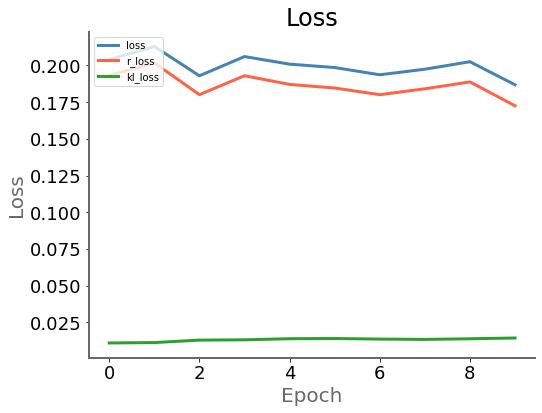

In [10]:
pwk.plot_history(history,  plot={"Loss":['loss','r_loss', 'kl_loss']}, save_as='history')

### 6.2 - Reconstruction during training
At the end of each epoch, our callback saved some reconstructed images.  
Where :  
Original image -> encoder -> z -> decoder -> Reconstructed image

<br>**Original images :**

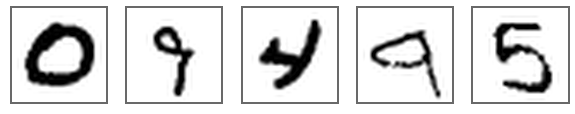

<br>**Encoded/decoded images**

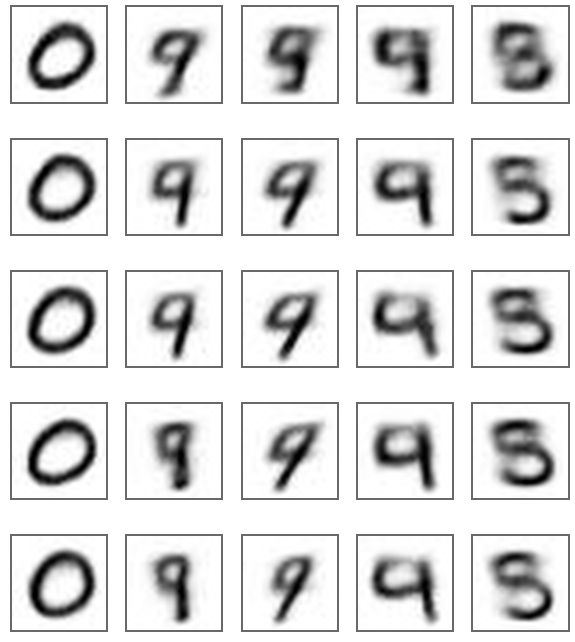

<br>**Original images :**

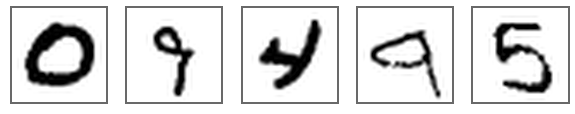

In [11]:
images_z, images_r = callback_images.get_images( range(0,epochs,2) )

pwk.subtitle('Original images :')
pwk.plot_images(x_data[:5], None, indices='all', columns=5, x_size=2,y_size=2, save_as='02-original')

pwk.subtitle('Encoded/decoded images')
pwk.plot_images(images_z, None, indices='all', columns=5, x_size=2,y_size=2, save_as='03-reconstruct')

pwk.subtitle('Original images :')
pwk.plot_images(x_data[:5], None, indices='all', columns=5, x_size=2,y_size=2, save_as=None)


### 6.3 - Generation (latent -> decoder) during training

<br>**Generated images from latent space**

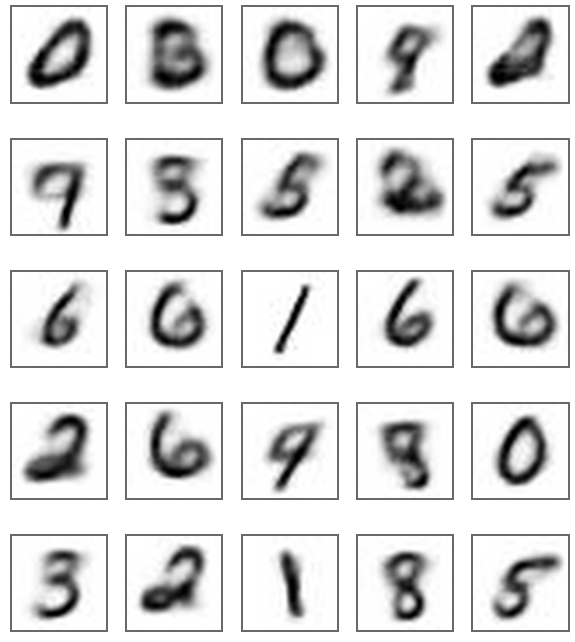

In [12]:
pwk.subtitle('Generated images from latent space')
pwk.plot_images(images_r, None, indices='all', columns=5, x_size=2,y_size=2, save_as='04-encoded')

## Step 7 - Model evaluation

### 7.1 - Reload best model

In [13]:
vae=VAE()
vae.reload(f'{run_dir}/models/best_model')

Fidle VAE is ready :-)  loss_weights=[1, 1]
Reloaded.


### 7.2 - Image reconstruction

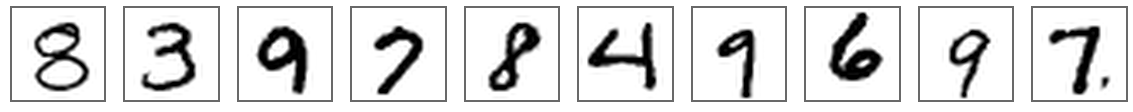

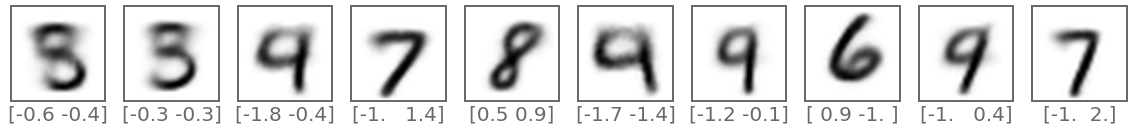

In [14]:
# ---- Select few images

x_show = pwk.pick_dataset(x_data, n=10)

# ---- Get latent points and reconstructed images

z_mean, z_var, z  = vae.encoder.predict(x_show)
x_reconst         = vae.decoder.predict(z)

# ---- Show it

labels=[ str(np.round(z[i],1)) for i in range(10) ]
pwk.plot_images(x_show,    None, indices='all', columns=10, x_size=2,y_size=2, save_as='05-original')
pwk.plot_images(x_reconst, labels  , indices='all', columns=10, x_size=2,y_size=2, save_as='06-reconstruct')


### 7.3 - Visualization of the latent space

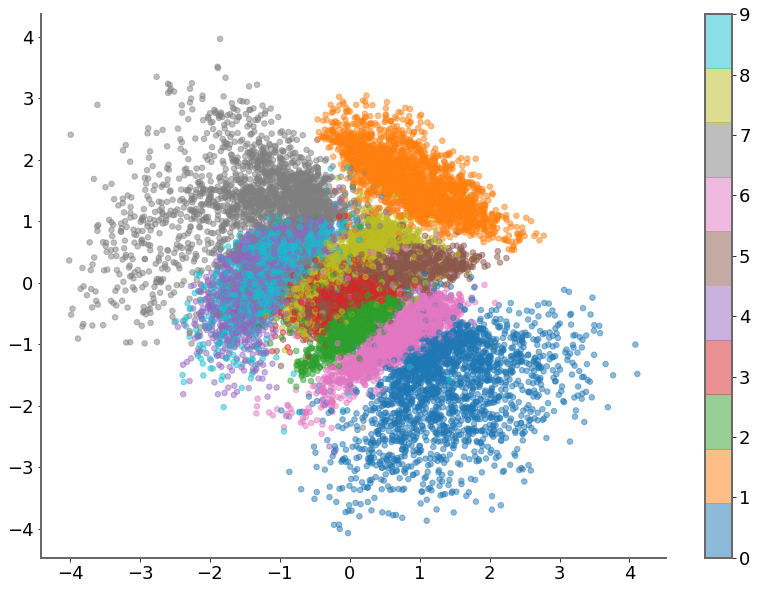

In [15]:
n_show = 20000

# ---- Select images

x_show, y_show = pwk.pick_dataset(x_data,y_data, n=n_show)

# ---- Get latent points

z_mean, z_var, z = vae.encoder.predict(x_show)

# ---- Show them

fig = plt.figure(figsize=(14, 10))
plt.scatter(z[:, 0] , z[:, 1], c=y_show, cmap= 'tab10', alpha=0.5, s=30)
plt.colorbar()
pwk.save_fig('07-Latent-space')
plt.show()

### 7.4 - Generative latent space

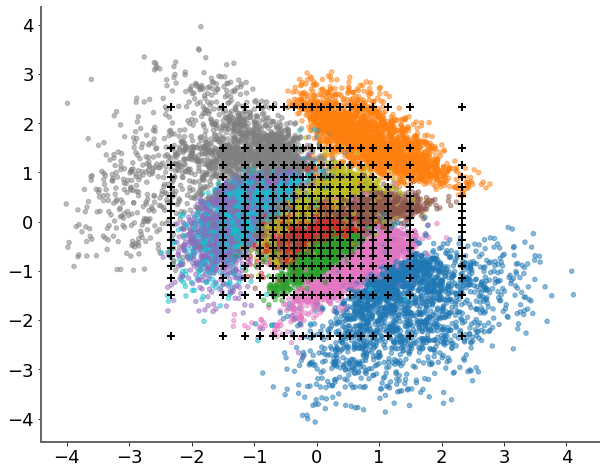

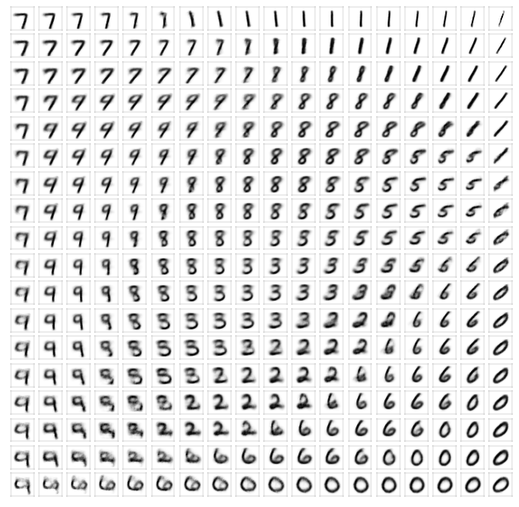

In [16]:
grid_size   = 18
grid_scale  = 1

# ---- Draw a ppf grid

grid=[]
for y in scipy.stats.norm.ppf(np.linspace(0.99, 0.01, grid_size),scale=grid_scale):
    for x in scipy.stats.norm.ppf(np.linspace(0.01, 0.99, grid_size),scale=grid_scale):
        grid.append( (x,y) )
grid=np.array(grid)

# ---- Draw latentspoints and grid

fig = plt.figure(figsize=(10, 8))
plt.scatter(z[:, 0] , z[:, 1], c=y_show, cmap= 'tab10', alpha=0.5, s=20)
plt.scatter(grid[:, 0] , grid[:, 1], c = 'black', s=60, linewidth=2, marker='+', alpha=1)
pwk.save_fig('08-Latent-grid')
plt.show()

# ---- Plot grid corresponding images

x_reconst = vae.decoder.predict([grid])
pwk.plot_images(x_reconst, indices='all', columns=grid_size, x_size=0.5,y_size=0.5, y_padding=0,spines_alpha=0.1, save_as='09-Latent-morphing')



In [17]:
pwk.end()

End time is : Monday 22 March 2021, 14:48:49
Duration is : 00:01:49 085ms
This notebook ends here


---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>